# DEAP - CIRUGÍAS

## Librerías

In [4]:
import operator
import random
import numpy as np
import pandas as pd
import operator
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools, gp
import time
import json
import sys
import math

print("Librerías cargadas.");

sys.path.append("./algorithm")

Librerías cargadas.


## Old

In [101]:
pset = gp.PrimitiveSet("MAIN", 0);

#TERMINALES
def asignar_primero(paciente, cirujano):
    if paciente in pacientes and cirujano in cirujanos and pacientes[paciente] in cirujanos[cirujano]:
        asignaciones[paciente] = cirujano

def quitar(paciente):
    if paciente in asignaciones:
        del asignaciones[paciente]

for paciente in pacientes:
    pset.addTerminal(paciente)

for cirujano in cirujanos:
    pset.addTerminal(cirujano)

pset.addPrimitive(asignar, 2)
pset.addPrimitive(quitar, 1)

pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.not_, 1)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSchedule(individual):
    global schedule, O, D, T, pacientes
    schedule.clear()
    func = toolbox.compile(expr=individual)
    func();
    score = 0
    pacientes_asign = [];
    for col in range(len(schedule[0])):
        p = schedule[0][col]
        if p != 0 and p not in pacientes_asign:
            pacientes_asign.append(p)
            score += pacientes[p][0]
    score *= 1000;
    penalizacion = 0;
    for o in O:
        for t in range(1, len(D) * len(T) + 1):
            registro = {};
            for col in range(len(schedule[0])):
                if schedule[0][col] == o:
                    bloque = schedule[3][col];
                    if bloque == t:
                        or_id = schedule[2][col]
                        if or_id in registro:
                            penalizacion += 100;
                        else:
                            registro[or_id] = 1;
    score -= penalizacion;
    return score, 


toolbox.register("evaluate", evalPlanificacion);
toolbox.register("select", tools.selTournament, tournsize=3);
toolbox.register("mate", gp.cxOnePoint);
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset);
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));

# Función principal para ejecutar el algoritmo genético
def main():
    random.seed(258)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 50, stats=mstats, halloffame=hof, verbose=True)
    best_ind = tools.selBest(pop, 1)[0]
    print("Mejor individuo es:", best_ind)
    print("Con un fitness de:", best_ind.fitness.values)

    return pop, log, hof

if __name__ == "__main__":
    main()

NameError: name 'pacientes' is not defined

In [ ]:
import numpy as np
import pandas as pd

pacientes_asign = set();
registros = set();

def evalAllORs(or_schedules):
    puntaje = 0
    for or_id, schedule in or_schedules.items():
        points = evalSchedule(schedule, or_id);
        puntaje += points;
        print(f"Score para OR {or_id}: {points}.\n");
    return puntaje

def evalSchedule(schedule, or_id):
    if schedule.size == 0:
        print(f"No hay asignaciones para este OR {or_id}.")
        return 0;
    bloques_por_paciente = {};
    penalizaciones = 0;
    registros = set();
    score = 0;
    for i in range(schedule.shape[1]):  #Recorrer todas las asignaciones en este OR
        paciente_id = schedule[0, i];
        cirujano_principal_id = schedule[1, i];
        cirujano_secundario_id = schedule[2, i];
        bloque_horario = schedule[3, i];
        prioridad_paciente = pacientes[paciente_id][1];
        if paciente_id not in bloques_por_paciente:
            bloques_por_paciente[paciente_id] = [];
            score += 1000 * prioridad_paciente;
        bloques_por_paciente[paciente_id].append(bloque_horario);
        especialidad_requerida = pacientes[paciente_id][0];
        if cirujanos[cirujano_principal_id] != especialidad_requerida:
            penalizaciones += 10;  #Penalización si la especialidad no coincide
            print(f"Penalización: Especialidad del cirujano no coincide para paciente {paciente_id} en OR {or_id}.");
        if cirujano_principal_id == cirujano_secundario_id:
            penalizaciones += 10;
            print(f"Penalización: Cirujano principal y secundario son la misma persona para paciente {paciente_id} en OR {or_id}.");
        if (cirujano_principal_id, bloque_horario) in registros:
            penalizaciones += 50;  #Penalización por asignar a un mismo bloque horario
            print(f"Penalización: Cirujano {cirujano_principal_id} reasignado en el mismo bloque {bloque_horario} en OR {or_id}.");
        registros.add((cirujano_principal_id, bloque_horario)); #Aregar
    for paciente_id, bloques in bloques_por_paciente.items():
        bloques.sort();
        duracion = pacientes[paciente_id][2];
        if len(bloques) != duracion:
            penalizaciones += 50 * len(bloques); #Penalizar por cada bloque asignaod mal
            print(f"Penalización: Duración incorrecta para paciente {paciente_id} en OR {or_id}. Esperado: {duracion}, Obtenido: {len(bloques)}.");
        if not all(bloques[i] + 1 == bloques[i + 1] for i in range(len(bloques) - 1)):
            penalizaciones += 100 * len(bloques); #Penalización por cada bloque no consecutivo
            print(f"Penalización: Bloques no consecutivos para paciente {paciente_id} en OR {or_id}.");

    score -= 10 * penalizaciones;  #Restar las penalizaciones del score total
    print(f"Score final para OR {or_id}: {score}");
    return score

### Validación

In [ ]:
or_schedules = {
    1: np.array([
        [1, 1],
        [1, 1],
        [2, 2],
        [1, 1]]),
    2: np.array([
        [3, 7, 6],
        [2, 2, 2],
        [1, 2, 1],
        [1, 2, 10]]),
    3: np.array([
        [4, 5],
        [3, 3],
        [4, 4],
        [2, 3]]),
    4: np.array([
        [0],
        [0],
        [0],
        [0]])};

pacientes_asign = set();
registros = set();
total_score = evalAllORs(or_schedules)
print("Score total:", total_score)

In [ ]:
def generar_solucion_factible(D, T):
    global pacientes, cirujanos, ors
    def encontrar_paciente_cirujano(asignados, especialidad):
        for paciente_id, (pac_esp, _, duracion) in pacientes.items():
            if paciente_id not in asignados and pac_esp == especialidad:
                for cirujano_id, cir_esp in cirujanos.items():
                    if cir_esp == especialidad:
                        cirujano_secundario_id = next((id for id in cirujanos if id != cirujano_id), None);
                        if cirujano_secundario_id:
                            return paciente_id, cirujano_id, cirujano_secundario_id, duracion
        return None, None, None, None

    def asignar_paciente(schedule, paciente_id, cirujano_principal_id, cirujano_secundario_id, day, block, duracion, T):
        for b in range(duracion):
            actual_block = (day - 1) * T + block + b;
            schedule.append([paciente_id, cirujano_principal_id, cirujano_secundario_id, actual_block]);

    def es_bloque_disponible(schedule, block, day, duracion, T):
        start_block = (day - 1) * T + block;
        end_block = start_block + duracion - 1;
        if end_block > day * T:
            return False
        existing_blocks = set(b for _, _, _, b in schedule);
        return all(b not in existing_blocks for b in range(start_block, end_block + 1))
    or_schedules = {or_id: [] for or_id in ors};
    asignados = set();
    for or_id, config in ors.items():
        for day in range(1, D + 1):
            morning_specialty, afternoon_specialty = config[day-1];
            for specialty, time_frame in [(morning_specialty, range(1, T // 2 + 1)), (afternoon_specialty, range(T // 2 + 1, T + 1))]:
                if specialty:
                    for block in time_frame:
                        if es_bloque_disponible(or_schedules[or_id], block, day, 1, T):
                            paciente_id, cirujano_principal_id, cirujano_secundario_id, duracion = encontrar_paciente_cirujano(asignados, specialty);
                            if paciente_id:
                                asignar_paciente(or_schedules[or_id], paciente_id, cirujano_principal_id, cirujano_secundario_id, day, block, duracion, T);
                                asignados.add(paciente_id);
                                break
    return {or_id: np.array(schedule).T if schedule else np.empty((4, 0)) for or_id, schedule in or_schedules.items()}

solucion_inicial = generar_solucion_factible(len(D), len(T));
print(solucion_inicial);

print(evalAllORs(solucion_inicial));

In [ ]:
def tabular_solucion(solucion, T):
    or_tables = {};
    for or_id, datos in solucion.items():
        if datos.size == 0:
            or_tables[or_id] = pd.DataFrame();
            continue
        df = pd.DataFrame(datos.T, columns=["Paciente", "Cirujano Principal", "Cirujano Secundario", "Bloque Horario"]);
        df["Día"] = (df["Bloque Horario"] - 1) // T + 1;
        df["Bloque en Día"] = (df["Bloque Horario"] - 1) % T + 1;
        df["Especialidad"] = df["Paciente"].apply(lambda x: pacientes[x][0]);
        #max_dias = df["Día"].max();
        max_dias = D[-1];
        tabla = pd.DataFrame(index=range(1, T+1), columns=range(1, max_dias+1));
        for _, row in df.iterrows():
            day = row["Día"];
            block = row["Bloque en Día"];
            tabla.at[block, day] = (row["Paciente"], row["Cirujano Principal"], row["Cirujano Secundario"], row["Especialidad"]);
        or_tables[or_id] = tabla;
    return or_tables

#print(tabular_solucion(solucion_inicial, len(T)));
tabular_solucion(solucion_inicial, len(T))[2].head(len(T))

## Cargar datos

In [25]:
testing = False;
parametroFichas = 0.11;
entrada = "instance3";
version = "C";
solucion_inicial = True;
print(f"Configurado con testing = {testing}. Versión: {version}. Entrada: {entrada}. Solución inicial: {solucion_inicial}.");

Configurado con testing = False. Versión: C. Entrada: instance3. Solución inicial: True.


In [26]:
import warnings
import json
import pandas as pd
import random
import numpy as np
import time

warnings.filterwarnings("ignore")

if testing == False:
    with open(f"../irace/instances/{entrada}.json") as file:
        data = json.load(file);
else:
    with open("../input/inst_test.json") as file:
        data = json.load(file);
    
#config = data["configurations"];
dfSolucion = pd.DataFrame();
dfSolucion.to_excel(f"../output/LPM/{entrada}_output.xlsx", index=False);
                    
dfSurgeon = pd.read_excel("../input/MAIN_SURGEONS.xlsx", sheet_name='surgeon', converters={'n°':int}, index_col=[0]);
dfSecond = pd.read_excel("../input/SECOND_SURGEONS.xlsx", sheet_name='second', converters={'n°':int}, index_col=[0]);
dfRoom = pd.read_excel("../input/ROOMS.xlsx", sheet_name='room', converters={'n°':int}, index_col=[0]);
dfType = pd.read_excel("../input/PROCESS_TYPE.xls", sheet_name='Process Type', converters={'n°':int}, index_col=[0]);
                    
extras = [];
dfdisORA = pd.read_excel("../input/DIST_OR_EXT.xlsx", sheet_name='A', converters={'n°':int}, index_col=[0]);
dfdisORA = dfdisORA.astype(str).values.tolist();
extraA = [];
for i in range(len(dfdisORA)):
    extraA.append(dfdisORA[i].copy());
for i in range(len(dfdisORA[0])):
    aux = dfdisORA[0][i].split(";");
    dfdisORA[0][i] = aux[0];
    extraA[0][i] = aux[1:];
    aux = dfdisORA[1][i];
    aux = aux.split(";");
    dfdisORA[1][i] = aux[0];
    extraA[1][i] = aux[1:];
    num_ext = len(extraA[1][i]);
extras.append(extraA);

dfdisORB = pd.read_excel("../input/DIST_OR_EXT.xlsx", sheet_name='B', converters={'n°':int}, index_col=[0]);
dfdisORB = dfdisORB.astype(str).values.tolist();
extraB = [];
for i in range(len(dfdisORB)):
    aux = dfdisORB[i].copy();
    extraB.append(aux);
for i in range(len(dfdisORB[0])):
    aux = dfdisORB[0][i];
    aux = aux.split(";");
    dfdisORB[0][i] = aux[0];
    extraB[0][i] = aux[1:];
    aux = dfdisORB[1][i];
    aux = aux.split(";");
    dfdisORB[1][i] = aux[0];
    extraB[1][i] = aux[1:];
extras.append(extraB);

dfdisORC = pd.read_excel("../input/DIST_OR_EXT.xlsx", sheet_name='C', converters={'n°':int}, index_col=[0]);
dfdisORC = dfdisORC.astype(str).values.tolist();
extraC = [];
for i in range(len(dfdisORC)):
    aux = dfdisORC[i].copy();
    extraC.append(aux);
for i in range(len(dfdisORC[0])):
    aux = dfdisORC[0][i];
    aux = aux.split(";");
    dfdisORC[0][i] = aux[0];
    extraC[0][i] = aux[1:];
    aux = dfdisORC[1][i];
    aux = aux.split(";");
    dfdisORC[1][i] = aux[0];
    extraC[1][i] = aux[1:];
extras.append(extraC);

dfdisORD = pd.read_excel("../input/DIST_OR_EXT.xlsx", sheet_name='D', converters={'n°':int}, index_col=[0]);
dfdisORD = dfdisORD.astype(str).values.tolist();
extraD = [];
for i in range(len(dfdisORD)):
    aux = dfdisORD[i].copy();
    extraD.append(aux);
for i in range(len(dfdisORD[0])):
    aux = dfdisORD[0][i];
    aux = aux.split(";");
    dfdisORD[0][i] = aux[0];
    extraD[0][i] = aux[1:];
    aux = dfdisORD[1][i];
    aux = aux.split(";");
    dfdisORD[1][i] = aux[0];
    extraD[1][i] = aux[1:];
extras.append(extraD);

dfdisAffi = pd.read_excel("../input/AFFINITY_EXT.xlsx", sheet_name='Hoja1', converters={'n°':int}, index_col=[0]);
dfdisAffiDiario = pd.read_excel("../input/AFFINITY_DIARIO.xlsx", sheet_name='Dias', converters={'n°':int}, index_col=[0]);
dfdisAffiBloque = pd.read_excel("../input/AFFINITY_DIARIO.xlsx", sheet_name='Bloques', converters={'n°':int}, index_col=[0]);
dfdisRank = pd.read_excel("../input/RANKING.xlsx", sheet_name = 'Hoja1', converters={'n°':int}, index_col=[0]);

extra = [];
dfExtra = [];
for i in range(num_ext):
    aux = pd.read_excel("../input/AFFINITY_EXT.xlsx", sheet_name='Extra'+str(i+1), converters = {'n°':int}, index_col=[0]);
    extra.append(len(aux));
    dfExtra.append(aux);

# Rankings para extras
dfRankExtra = [];
for i in range(num_ext):
    aux = pd.read_excel("../input//RANKING.xlsx", sheet_name='Extra'+str(i+1), converters = {'n°':int}, index_col=[0]);
    extra.append(len(aux));
    dfRankExtra.append(aux);

#-------------------------------------------------------------------------------------------------------------------------------#     
########################################################### MAIN LOOP ###########################################################
#-------------------------------------------------------------------------------------------------------------------------------#  

dfSolucion = pd.read_excel(f"../output/LPM/{entrada}_output.xlsx");
#version = INS["version"];
typePatients = data["patients"];
nPatients = int(data["n_patients"]);
nDays = int(data["days"]);
min_affinity = int(data["min_affinity"]);
nSurgeons = int(data["surgeons"]);
nFichas = int(data["fichas"]);
time_limit = int(data["time_limit"]);
bks = int(data["bks"]);

patient_code = "0" if typePatients == "low" else ("1" if typePatients == "high" else "2");
print(f"Versión: {version};\nPacientes: {typePatients}; Días: {nDays};\nAfinidad: {min_affinity}; Cirujanos: {nSurgeons};\nFichas: {nFichas}.");

#list_sol = [instancia[INS][0]+"_"+instancia[INS][1],"","","","","","","","","","","","","",""];
dict_sol = {"Instancia": [f"v{version}p{patient_code}s{nSurgeons}d{nDays}"]};

if typePatients == "low":
    dfPatient = pd.read_csv("../input/LowPriority.csv");
elif typePatients == "high":
    dfPatient = pd.read_csv("../input/HighPriority.csv");
else:
    dfPatient = pd.read_csv("../input/AllPriority.csv");

dfPatient = dfPatient.iloc[:nPatients];
print(f"Considerando {len(dfPatient)} pacientes.")

# Indices
random.seed(0);
patient = [p for p in range(nPatients)];
surgeon = [s for s in range(nSurgeons)];
second = [a for a in range(nSurgeons)]
room = [o for o in range(len(dfRoom))]
day = [d for d in range(nDays)];
nSlot = 16;  # Bloques de 30 minutos
nRooms = len(room);
slot = [t for t in range(nSlot)]
T = nSlot//2; # División entre mañana y tarde

process=[t for t in range(len(dfType))] # ?
level_affinity = min_affinity;

# Arcos
arcox = [(p,o,s,a,t,d) for p in patient for o in room for s in surgeon for a in second for t in slot for d in day];
arcoy = [(p,o,d) for p in patient for o in room for d in day];
arcoz = [(p,s,a) for p in patient for s in surgeon for a in second];
arcot = [p for p in patient];
arcof = [(s,d) for s in surgeon for d in [a for a in range(-1, nDays)]];

#Max surgeries and budget per surgeon
M = np.zeros(nSurgeons, dtype=int);
Pr = np.zeros(nSurgeons, dtype=int);
for s in surgeon:
    M[s] = int(dfSurgeon.iloc[s][8]); # Máximo de cirugías
    Pr[s] = int(dfSurgeon.iloc[s][11]); # Presupuesto de fichas

E = np.ones((nSlot, nDays)) * 1000; # ? 
A = np.ones((nSlot, nDays)) * 1000; # ?
B = np.ones(nPatients) * 1; # ?
Y = np.ones(nPatients) * 1; # ?

# Prioridades
I = np.ones((nPatients, nDays), dtype=int);
for p in patient:
    for d in day:
        try:
            I[(p,d)] = 1 + dfPatient.iloc[p]["espera"] * dfPatient.iloc[p]["edad"] * 0.0001/(d+1);
        except ValueError:
            print("Value Error en cálculo de prioridades.");

# Matriz de coincidencia cirujanos
COIN = np.zeros((nSurgeons, nSurgeons), dtype=int);
for s in surgeon:
    for a in second:
        if dfSurgeon.iloc[s][0] == dfSecond.iloc[a][0]:
            COIN[(s,a)] = 1;
        else:
            COIN[(s,a)] = 0;
            

Ex = [np.ones((nSurgeons, extra[i]), dtype=float) for i in range(num_ext)];
for i in range(num_ext):
    for s in surgeon:
        for e in range(extra[i]):
            Ex[i][(s,e)] = dfExtra[i].iloc[e][s+1];

# Disponibilidad de cirujanos
# SD = np.zeros((nSurgeons, nSurgeons, nSlot, nDays%5), dtype=int);
# for s in surgeon:
#     for a in second:
#         for d in day:
#             if dfSurgeon.iloc[s][2+d%5] == 1:
#                 if dfSecond.iloc[a][2+d%5] == 1:
#                     if dfSurgeon.iloc[s][1] == 1:
#                         if dfSecond.iloc[a][1] == 1:
#                             for t in range(nSlot//T):
#                                 SD[(s,a,t%2,d%5)] = 1;
#                     if dfSurgeon.iloc[s][2] == 1:
#                         if dfSecond.iloc[a][2] == 1:
#                             for t in range(nSlot//T, nSlot):
#                                 SD[(s,a,t%2,d%5)] = 1;

# Disponibilidad de paciente
DISP = np.ones(nPatients);

def busquedaType(especialidad):
    indice = 0;
    for i in range(len(process)):
        if (especialidad == dfType.iloc[i][0]):
            indice = i;
    return indice

# Compatibilidad paciente-cirujano
SP = np.zeros((nPatients, nSurgeons), dtype=int);
contador = 0;
for p in patient:
    #print(dfPatient.iloc[p][21])
    for s in surgeon:
        if busquedaType(dfPatient.iloc[p]["especialidad"]) == busquedaType(dfSurgeon.iloc[s][9]):
            #print(dfPatient.iloc[p][21])
            SP[p][s] = 1;       

# Schedules para los quirófanos
OR_specialties = {};
for o in range(len(room)):
    for d in range(5):
        for t in range(2):
            if o == 0:
                aux = dfdisORA[t][d];
            elif o == 1:
                aux = dfdisORB[t][d];
            elif o == 2:
                aux = dfdisORC[t][d];
            elif o == 3:
                aux = dfdisORD[t][d];
            OR_specialties[(o, d, t)] = aux;

# Diccionario de paciente
dic_p = {p: [0, 0, 0, 0, 0] for p in patient};
for p in patient:
    #dic_p[p][0] = list_patient[p] #paciente y número aleatorio asociado (entre 0 y 1)
    dic_p[p][1] = busquedaType(dfPatient.iloc[p]["especialidad"]) # ID Especialidad
    dic_p[p][2] = dfPatient.iloc[p]["nombre"]; #Nombre del paciente
    dic_p[p][3] = p; # ID
    dic_p[p][4] = dfPatient.iloc[p]["especialidad"]; # Especialidad requerida

# Compatibilidad quirófano-paciente
AOR = np.zeros((nPatients, nRooms, nSlot, 5));
dicOR = {o:[] for o in room};
j = [];
z = [];
ns = 0;
for o in room:
    if o == 0:
        for d in range(5):
            for e in range(2):
                #print(e)
                if e == 0:                    
                    for t in range(len(slot)//2):

                        j = dfdisORA[e][d%5];
                        j = j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d%5,t,z]
                            ns+=1
                if e==1:
                    #print('paso')
                    for t in range(int(len(slot)/2),len(slot)):

                        j=dfdisORA[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d%5,t,z]
                            ns+=1
    if o==1:
        for d in range(5):
            for e in range(2):
                if e==0:                    
                    for t in range(0,int(len(slot)/2)):
                        j=dfdisORB[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1
                if e==1:
                    for t in range(int(len(slot)/2),len(slot)):
                        j=dfdisORB[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1
    if o==2:
        for d in range(5):
            for e in range(2):
                if e==0:                    
                    for t in range(0,int(len(slot)/2)):
                        j=dfdisORC[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1
                if e==1:
                    for t in range(int(len(slot)/2),len(slot)):
                        j=dfdisORC[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1
    if o==3:
        for d in range(5):
            for e in range(2):
                if e==0:                    
                    for t in range(0,int(len(slot)/2)):
                        j=dfdisORD[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1
                if e==1:
                    for t in range(int(len(slot)/2),len(slot)):
                        j=dfdisORD[e][d%5]
                        j=j.split("#")
                        for a in range(len(j)):
                            z=j[a]
                            dicOR[ns]=[o,d,t,z]
                            ns+=1

p = 0;
o = 0;
t = 0;

for ns in range(len(dic_p)):
    for nP in range(len(dicOR)):
        #print(dicOR[nP][3])
        if str(dic_p[ns][1])==dicOR[nP][3]:
            p = dic_p[ns][3];
            o = dicOR[nP][0];
            t = dicOR[nP][2];
            d = dicOR[nP][1];
            AOR[p][o][t][d%5] = 1;

OT = np.zeros(nPatients, dtype=int);
for p in patient:
    OT[p] = int(dfPatient.iloc[p]["tipo"]);
nFichas = int((parametroFichas * 4 * nSlot * len(room) * 2 * 3 )/(len(surgeon)**0.5));
print("Nuevas fichas:", nFichas);
print("_" * 160);
print('Datos Obtenidos.');

Versión: C;
Pacientes: all; Días: 1;
Afinidad: 1; Cirujanos: 24;
Fichas: 40.
Considerando 150 pacientes.
Nuevas fichas: 34
________________________________________________________________________________________________________________________________________________________________
Datos Obtenidos.


## Construcción de diccionario de "costos" de fichas instantáneo, v1.0

In [27]:
def compress(o, d, t):
    return o * nSlot * nDays + d * nSlot + t

def decompress(val):
    o = (val) // (nSlot * nDays);
    temp = (val) % (nSlot * nDays);
    d = temp // nSlot;
    t = temp % nSlot;
    return o, d, t

def WhichExtra(o,t,d,e):
    try:
        return int(extras[o][t][d%5][e]);
    except:
        print(f'extras: d:{d},t:{t},o:{o},e:{e}');
        print(stop)

dictCosts = {};

for s in surgeon:
    for a in second:
        for _ in range(nSlot * nDays * len(room)):
            o, d, t = decompress(_);
            dictCosts[(s, a, _)] = int(dfdisAffi.iloc[a][s+1] + dfdisAffiDiario.iloc[d%5][s+1] + sum(Ex[i][(s,WhichExtra(o,t//T,d,i)-1)] for i in range(num_ext)) + dfdisAffiBloque.iloc[t//T][s+1]);
            
#print(dictCosts);
print("Todo listo.");

Todo listo.


# Evaluación de solución

In [28]:
def EvalAllORs(sol, VERSION="A", hablar=False):
    fichas = [[nFichas * (d+1) for d in range(len(day))] for s in surgeon]
    pacientes, primarios, secundarios = sol

    def evalSchedule(pacientes, primarios, secundarios, or_id, hablar=False):
        bloques_por_paciente = {}
        penalizaciones = 0
        score_or = 0

        for p_idx in range(len(pacientes)):
            if pacientes[p_idx] != -1:
                o_p, d_p, t_p = decompress(pacientes[p_idx])
                if o_p == or_id:
                    duracion = OT[p_idx]
                    prioridad_paciente = I[(p_idx, d_p)]
                    s = primarios[pacientes[p_idx]]
                    a = secundarios[pacientes[p_idx]]

                    if p_idx not in bloques_por_paciente:
                        bloques_por_paciente[p_idx] = []
                        score_or += 1000 * prioridad_paciente
                        s_idx = surgeon.index(s)
                        cost = dictCosts[(s, a, pacientes[p_idx])]
                        for d_aux in range(d_p, nDays):
                            fichas[s_idx][d_aux] -= cost

                    for b in range(int(duracion)):
                        t_actual = t_p + b
                        bloque_horario = compress(o_p, d_p, t_actual)
                        bloques_por_paciente[p_idx].append(bloque_horario)
                        if SP[p_idx][s] != 1:
                            penalizaciones += 10
                            if hablar:
                                print(f"[OR={or_id}] Penalización: Cirujano {s} no coincide con paciente {p_idx}.")
                        if s == a:
                            penalizaciones += 10
                            if hablar:
                                print(f"[OR={or_id}] Penalización: Cirujano principal y asistente son la misma persona (pIdx={p_idx}).")

        for paciente_id, bloques in bloques_por_paciente.items():
            bloques.sort()
            duracion = OT[paciente_id]
            if len(bloques) != duracion:
                penalizaciones += 50 * len(bloques)
                if hablar:
                    print(f"[OR={or_id}] Pen: Duración incorrecta para pac {paciente_id}.")
            if not all(bloques[i]+1 == bloques[i+1] for i in range(len(bloques)-1)):
                penalizaciones += 100 * len(bloques)
                if hablar:
                    print(f"[OR={or_id}] Pen: Bloques no consecutivos para pac {paciente_id}.")

        score_or -= 10 * penalizaciones
        return score_or

    puntaje = 0
    for or_id in room:
        score_for_or = evalSchedule(pacientes, primarios, secundarios, or_id, hablar)
        puntaje += score_for_or
        if hablar:
            print(f"Score parcial OR={or_id}: {score_for_or}")

    for s_idx, s in enumerate(surgeon):
        for d_idx in range(nDays):
            if fichas[s_idx][d_idx] < 0:
                penalizacion_fichas = 100 * abs(fichas[s_idx][d_idx])
                puntaje -= penalizacion_fichas
                if hablar:
                    print(f"Penalización por fichas negativas: Cirujano {s}, día {d_idx}, fichas={fichas[s_idx][d_idx]}.")

    if VERSION == "C":
        def multiplicador(day_idx):
            return (nDays // (day_idx + 1))
        for s_idx, s in enumerate(surgeon):
            for d_idx in range(nDays):
                leftover_fichas = fichas[s_idx][d_idx]
                puntaje -= leftover_fichas * multiplicador(d_idx)

    if hablar:
        print("Puntaje final (después de restar fichas' sobrantes):", puntaje)
        print("Fichas restantes (por cirujano/día):")
        for s_idx, s in enumerate(surgeon):
            print(f"  Cirujano {s}: {fichas[s_idx]}")

    return puntaje

## Generar Solución Factible

In [43]:
def generar_solucion_inicial(VERSION="A", hablar=True):
    all_personnel = set(surgeon).union(second);
    timeUsedMap = { person: set() for person in all_personnel};
    boundary = nSlot//2;

    def encontrar_pacientes_cirujanos(p):
        compatibles = [];
        for s in surgeon:
            if SP[p][s] == 1:
                for a in second:
                    if a != s and COIN[s][a] == 0:
                        compatibles.append((p, s, a, OT[p]));
        return compatibles

    def cirujano_disponible(s, a, o, d, t, duracion):
        for b in range(int(duracion)):
            if (d, t + b) in timeUsedMap[s]:
                return False
            if (d, t + b) in timeUsedMap[a]:
                return False
        return True

    def asignar_paciente(p, s, a, o, d, t, duracion):
        if asignP[p] == -1:
            asignP[p] = compress(o, d, t);
            for b in range(int(duracion)):
                or_schedule[o][d][t + b] = p;
                surgeon_schedule[s][d][t + b] = p;
                surgeon_schedule[a][d][t + b] = p;

                id_block = compress(o, d, t + b);
                dictS[id_block] = s;
                dictA[id_block] = a;
                timeUsedMap[s].add((d, t + b));
                timeUsedMap[a].add((d, t + b));
            asignS[s].add((o, d, t, duracion));
            asignA[a].add((o, d, t, duracion));

    patient_sorted = sorted(patient, key=lambda p: I[(p, 0)], reverse=True);

    asignP = [-1] * len(patient);
    asignS = {s: set() for s in surgeon};
    asignA = {a: set() for a in second};
    dictS  = {};
    dictA  = {};
    fichas = {(s, d): nFichas * (d+1) for s in surgeon for d in day};

    surgeon_schedule = {s: [[-1 for t in slot] for d in day] for s in surgeon};
    or_schedule = {o: [[-1 for t in slot] for d in day] for o in room};

    for p in patient_sorted:
        assigned = False
        duracion_p = OT[p]
        for o in room:
            for d in day:
                for t in range(nSlot - duracion_p + 1):
                    if duracion_p > 1:
                        if t < boundary and (t + duracion_p) > boundary:
                            continue
                    if all(AOR[p][o][t + b][d % 5] == 1 for b in range(duracion_p)):
                        #if es_bloque_disponible(o, d, t, duracion_p):
                        if all(or_schedule[o][d][t + b] == -1 for b in range(duracion_p)):
                            resultados = encontrar_pacientes_cirujanos(p)
                            for (p_res, s, a, dur) in resultados:
                                if cirujano_disponible(s, a, o, d, t, dur):
                                    if (dfdisAffi.iloc[a][s+1] >= level_affinity*(VERSION=="B") and
                                        dfdisAffiDiario.iloc[d % 5][s+1] >= level_affinity*(VERSION=="B") and
                                        dfdisAffiBloque.iloc[t // (nSlot // 2)][s+1] >= level_affinity*(VERSION=="B")):
                                        checks = 0;
                                        for i in range(num_ext):
                                            e = int(WhichExtra(o,t//8,d%5,i));
                                            if Ex[i][(s,e-1)] >= level_affinity*(VERSION=="B"):
                                                checks += 1;
                                        if checks >= num_ext*(VERSION=="B"):
                                            cost = dictCosts[(s, a, compress(o, d, t))]
                                            if all(fichas[(s, d_aux)] >= cost*(VERSION=="C") for d_aux in range(d, len(day))):
                                                asignar_paciente(p_res, s, a, o, d, t, dur)
                                                for d_aux in range(d, len(day)):
                                                    fichas[(s, d_aux)] -= cost;
                                                    #print(f"{d_aux}. costo: {cost}, fichas {s} {d}:", fichas[(s,d)])
                                                assigned = True
                                                break
                                if assigned:
                                    break
                if assigned:
                    break
            if assigned:
                break

    print("Solución inicial creada...")
    print("Fichas restantes (por cirujano/día):")
    for s in surgeon:
        fichas_por_dia = [fichas[(s, d)] for d in day];
        print(f"  Cirujano {s}: {fichas_por_dia}");
    print("Costo:", EvalAllORs((asignP, dictS, dictA), VERSION=version))
    return (asignP, dictS, dictA), surgeon_schedule, or_schedule, fichas

solucion_inicial = generar_solucion_inicial(VERSION=version, hablar=False)
print(solucion_inicial[1])

Solución inicial creada...
Fichas restantes (por cirujano/día):
  Cirujano 0: [36]
  Cirujano 1: [3]
  Cirujano 2: [2]
  Cirujano 3: [48]
  Cirujano 4: [2]
  Cirujano 5: [0]
  Cirujano 6: [3]
  Cirujano 7: [4]
  Cirujano 8: [37]
  Cirujano 9: [48]
  Cirujano 10: [4]
  Cirujano 11: [8]
Costo: 68680
{0: [[149, 33, 33, 88, 5, 7, 8, 18, 114, 145, 125, 16, 37, 69, 69, 11]], 1: [[17, 83, 98, 98, 123, 134, 32, 35, 114, 145, 13, 41, 42, 44, -1, 11]], 2: [[17, 83, 98, 98, 123, 134, 32, -1, 0, 4, -1, -1, -1, -1, -1, -1]], 3: [[39, 100, 1, 2, 2, 3, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]], 4: [[-1, -1, -1, -1, -1, -1, -1, -1, 0, 4, -1, -1, -1, -1, -1, -1]], 5: [[149, 33, 33, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], 6: [[39, 100, 1, 2, 2, 3, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]], 7: [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 125, 16, 37, 69, 69, -1]], 8: [[-1, -1, -1, -1, -1, -1, -1, 35, -1, -1, -1, -1, -1, -1, -1, -1]], 9: [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [29]:
sys.path.append("../algorithm");
import importlib
import initial_solutions
importlib.reload(initial_solutions);
from initial_solutions import GRASP

sol_inicial = GRASP(surgeon, second, patient, room, day, slot, AOR, I, dictCosts, nFichas, nSlot, SP, COIN, OT, alpha=0.2, VERSION="C", hablar=False);
EvalAllORs(sol_inicial[0], VERSION="C", hablar=False)

89501

In [30]:
import copy
sol_inicial = generar_solucion_inicial(VERSION=version);
def check_synchronized(sol, OT):
    surgeon_schedule_copy = copy.deepcopy(sol[1])
    or_schedule_copy = copy.deepcopy(sol[2])
    fichas_copy = copy.deepcopy(sol[3])
    pacientes_copy = copy.deepcopy(sol[0][0])
    primarios_copy = copy.deepcopy(sol[0][1])
    secundarios_copy = copy.deepcopy(sol[0][2])

    # 1) Build a dict: block -> patient that claims it
    block_to_patient = {}
    for p_idx, blk_start in enumerate(pacientes_copy):
        if blk_start != -1:  # assigned patient
            duration = OT[p_idx]
            for b in range(duration):
                blk = blk_start + b
                if blk in block_to_patient:
                    other_p = block_to_patient[blk]
                    msg = (f"Block {blk} is assigned to TWO patients: {p_idx} and {other_p}. "
                           "MISMATCH => concurrency error.")
                    #graficar_solucion(sol)
                    raise Exception(msg)
                block_to_patient[blk] = p_idx

    # 2) For every block in primarios/secundarios, check it belongs to a single patient
    for blk in primarios_copy.keys():
        if blk not in block_to_patient:
            #graficar_solucion(sol)
            raise Exception(f"Block {blk} is in primarios but no patient claims it in `pacientes`.")
    for blk in secundarios_copy.keys():
        if blk not in block_to_patient:
            #graficar_solucion(sol)
            raise Exception(f"Block {blk} is in secundarios but no patient claims it in `pacientes`.")

    # 3) For every assigned patient, check that each block exists in the dictionaries
    for p_idx, blk_start in enumerate(pacientes_copy):
        if blk_start != -1:
            duration = OT[p_idx]
            for b in range(duration):
                blk = blk_start + b
                if blk not in primarios_copy:
                    #graficar_solucion(sol)
                    raise Exception(f"Patient {p_idx} expects block {blk} in `primarios`, but not found.")
                if blk not in secundarios_copy:
                    #graficar_solucion(sol)
                    raise Exception(f"Patient {p_idx} expects block {blk} in `secundarios`, but not found.")
                
    for s_idx, s in enumerate(surgeon):
        for d_idx in range(nDays):
            if fichas_copy[(s, d_idx)] < 0:
                #graficar_solucion(sol)
                raise Exception(f"Negative fichas for surgeon {s} on day {d_idx}: {fichas_copy[(s, d_idx)]}")

    return True
check_synchronized(sol_inicial, OT)

NameError: name 'generar_solucion_inicial' is not defined

## Evaluar Solución

In [31]:
print(EvalAllORs(sol_inicial[0], VERSION=version, hablar=True))

Score parcial OR=0: 14000
Score parcial OR=1: 4000
Score parcial OR=2: 39000
Score parcial OR=3: 33000
Puntaje final (después de restar fichas' sobrantes): 89501
Fichas restantes (por cirujano/día):
  Cirujano 0: [34]
  Cirujano 1: [0]
  Cirujano 2: [9]
  Cirujano 3: [34]
  Cirujano 4: [7]
  Cirujano 5: [1]
  Cirujano 6: [0]
  Cirujano 7: [34]
  Cirujano 8: [34]
  Cirujano 9: [34]
  Cirujano 10: [0]
  Cirujano 11: [8]
  Cirujano 12: [12]
  Cirujano 13: [34]
  Cirujano 14: [34]
  Cirujano 15: [34]
  Cirujano 16: [34]
  Cirujano 17: [7]
  Cirujano 18: [2]
  Cirujano 19: [34]
  Cirujano 20: [34]
  Cirujano 21: [34]
  Cirujano 22: [34]
  Cirujano 23: [11]
89501


## Graficar Solución

In [28]:
import pandas as pd
from tabulate import tabulate
from collections import defaultdict

def graficar_solucion(sol, filename="schedule.html"):
    # Cargar nombres de especialidades
    df_specialties = pd.read_excel("../input/PROCESS_TYPE.xls", sheet_name='Process Type', converters={'n°': int})
    specialty_names = df_specialties.set_index('ID')['Nombre'].to_dict()

    # Colores para las especialidades
    specialty_colors = {
        0: "#FFE5E5",  # Light red
        1: "#E5FFE5",  # Light green
        2: "#E5E5FF",  # Light blue
        3: "#FFFFE5",  # Light yellow
        4: "#FFE5FF",  # Light purple
        5: "#E5FFFF",  # Light cyan
        6: "#FFE0B2",  # Light orange
        7: "#E1BEE7",  # Light violet
        8: "#B2DFDB",  # Light teal
        9: "#FFCDD2",  # Light pink
    }
    pacientes = sol[0];
    primarios = sol[1];
    secundarios = sol[2];

    total_patients = len(patient);
    assigned_patients = sum(1 for p in patient if pacientes[p] != -1);
    assigned_pct = (assigned_patients / total_patients) * 100 if total_patients > 0 else 0;

    total_priority = 0
    for p in patient:
        blk = pacientes[p]
        if blk != -1:
            o_p, d_p, t_p = decompress(blk)
            total_priority += I[(p, d_p)]

    schedules = {
        d: {
            o: {t: None for t in slot}
            for o in room
        }
        for d in range(nDays)
    }

    occupant_surgeons = defaultdict(list)
    patient_assignments = defaultdict(list)

    for p in patient:
        if pacientes[p] != -1:
            o_p, d_p, t_p = decompress(pacientes[p])
            duracion = OT[p]
            prim = primarios[pacientes[p]]
            sec = secundarios[pacientes[p]]
            for b in range(int(duracion)):
                t_actual = t_p + b
                if 0 <= t_actual < nSlot:
                    schedules[d_p][o_p][t_actual] = (p, prim, sec)
                    occupant_surgeons[(d_p, t_actual)].append((p, prim, sec, o_p))
                    patient_assignments[p].append((d_p, o_p, t_actual))

    invalid_cells = set()
    for (d, t), assignments in occupant_surgeons.items():
        surgeon_count = defaultdict(int)
        for (p, prim, sec, or_id) in assignments:
            if SP[p][prim] != 1:
                invalid_cells.add((d, or_id, t))
            if prim == sec:
                invalid_cells.add((d, or_id, t))

            surgeon_count[prim] += 1
            surgeon_count[sec] += 1

        for srg, num_assigned in surgeon_count.items():
            if num_assigned > 1:
                for (p, prim, sec, or_id) in assignments:
                    if prim == srg or sec == srg:
                        invalid_cells.add((d, or_id, t))

    # 2) Validar que los bloques sean consecutivos
    for p, blocks in patient_assignments.items():
        dur = OT[p]
        if dur > 1:
            day_or_map = defaultdict(list)
            for (d, o_id, t) in blocks:
                day_or_map[(d, o_id)].append(t)
            for (d, o_id), times in day_or_map.items():
                times.sort()
                if len(times) != dur:
                    # No se asignaron tantos tiempos como la duración
                    for t_ in times:
                        invalid_cells.add((d, o_id, t_))
                else:
                    expected_times = set(range(times[0], times[0] + dur))
                    if set(times) != expected_times:
                        # No son consecutivos
                        for t_ in times:
                            invalid_cells.add((d, o_id, t_))

    # Construimos las tablas HTML (por cada día)
    table_htmls = {}
    for d in range(nDays):
        headers = ["Time"] + [f"OR {o}" for o in room]
        data = []
        for t in range(nSlot):
            row = [f"t {t:02d}"]
            for o in room:
                asignacion = schedules[d][o][t]
                specialty_id = int(OR_specialties[(o, d, t//8)])  # Especialidad teórica de la OR
                bg_color = specialty_colors.get(specialty_id, "#FFFFFF")

                if asignacion is None:
                    tooltip_str = "No patient scheduled"
                    cell_str = (
                        f'<div class="cell" '
                        f'style="background-color: {bg_color};" '
                        f'data-tooltip="{tooltip_str}">'
                        f'---</div>'
                    )
                else:
                    p, prim, sec = asignacion
                    invalid_reason = []

                    # Chequeo si es celda inválida
                    if (d, o, t) in invalid_cells:
                        # Reunir razones
                        if SP[p][prim] != 1:
                            invalid_reason.append("Incompatible specialty")

                        # Surgen double-booked
                        if any(
                            len([x for x in occupant_surgeons[(d, t)] if x[1] == s or x[2] == s]) > 1
                            for s in [prim, sec]
                        ):
                            invalid_reason.append("Surgeon double-booked")

                        # Main == secondary
                        if prim == sec:
                            invalid_reason.append("Main surgeon == secondary surgeon")

                        # No consecutivo
                        if OT[p] > 1 and not all(
                            (d, o, t + i) in [(x[0], x[1], x[2]) for x in patient_assignments[p]]
                            for i in range(int(OT[p]))
                        ):
                            invalid_reason.append("Non-consecutive blocks")

                        tooltip = f"Patient: {dfPatient.iloc[p]['nombre']}"
                        if invalid_reason:
                            tooltip += f"\nInvalid because: {'; '.join(invalid_reason)}"

                        # Pintar celda con color de la especialidad real del paciente
                        pat_spec = busquedaType(dfPatient.iloc[p]["especialidad"])
                        bg_color = specialty_colors.get(pat_spec, "#FFFFFF")

                        cell_str = (
                            f'<div class="cell invalid" '
                            f'style="background-color: {bg_color};" '
                            f'data-tooltip="{tooltip}">'
                            f'p: {p:03d} m: {prim:02d} s: {sec:02d}</div>'
                        )
                    else:
                        tooltip = f"Patient: {dfPatient.iloc[p]['nombre']}"
                        # Color según la especialidad real del paciente
                        pat_spec = busquedaType(dfPatient.iloc[p]["especialidad"])
                        bg_color = specialty_colors.get(pat_spec, "#FFFFFF")
                        cell_str = (
                            f'<div class="cell" '
                            f'style="background-color: {bg_color};" '
                            f'data-tooltip="{tooltip}">'
                            f'p: {p:03d} m: {prim:02d} s: {sec:02d}</div>'
                        )

                row.append(cell_str)
            data.append(row)
        table_htmls[d] = tabulate(data, headers=headers, tablefmt="unsafehtml")

    # ========================
    # Cálculo de proporción por especialidad
    # ========================
    # Contamos cuántos pacientes hay en total por especialidad y cuántos asignados
    spec_counts = defaultdict(lambda: [0, 0])  # {spec_id: [assigned_count, total_count]}
    for p_idx in range(total_patients):
        spec_id = busquedaType(dfPatient.iloc[p_idx]["especialidad"])
        spec_counts[spec_id][1] += 1  # total
        if pacientes[p_idx] != -1:
            spec_counts[spec_id][0] += 1  # assigned

    # Construir HTML de la leyenda con la proporción
    legend_html = """
    <div class="legend">
        <h3>Specialties</h3>
"""
    for specialty, name in specialty_names.items():
        assigned_sp, total_sp = spec_counts[specialty]
        if total_sp == 0:
            ratio_str = "(0/0 = 0%)"
        else:
            ratio_pct = (assigned_sp / total_sp) * 100
            ratio_str = f"({assigned_sp}/{total_sp} = {ratio_pct:.1f}%)"
        color = specialty_colors.get(specialty, "#FFFFFF")

        legend_html += f"""
        <div class="legend-item">
            <div class="legend-color" style="background-color: {color}"></div>
            <div>{name} {ratio_str}</div>
        </div>
"""
    legend_html += "</div>"

    # HTML final
    html_code = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
<style>
  body {{
      font-family: Arial, sans-serif;
      margin: 20px;
      display: grid;
      grid-template-columns: 1fr auto;
      gap: 20px;
  }}
  table {{
      border-collapse: collapse;
      margin: 0 auto;
  }}
  th, td {{
      border: 1px solid #444;
      padding: 5px;
      text-align: center;
      width: 150px;
      position: relative;
  }}
  th:first-child, td:first-child {{
      width: 60px;
  }}
  .main-content {{
      display: flex;
      flex-direction: column;
      align-items: center;
      max-width: 80%;
  }}
  .legend {{
      background: white;
      padding: 20px;
      border-radius: 8px;
      box-shadow: 0 0 10px rgba(0,0,0,0.1);
      position: fixed;
      right: 20px;
      top: 20px;
      max-height: calc(100vh - 40px);
      overflow-y: auto;
  }}
  .legend-item {{
      display: flex;
      align-items: center;
      margin: 5px 0;
  }}
  .legend-color {{
      width: 20px;
      height: 20px;
      margin-right: 10px;
      border: 1px solid #ccc;
  }}
  .slider-container {{
      margin: 20px 0;
      text-align: center;
  }}
  .slider {{
      width: 300px;
  }}
  .cell {{
      padding: 3px;
      border-radius: 3px;
      position: relative;
  }}
  .invalid {{
      color: red;
      position: relative;
  }}
  .invalid::before {{
      content: '';
      position: absolute;
      top: 0;
      left: 0;
      right: 0;
      bottom: 0;
      background-color: rgba(255, 0, 0, 0.7);
      border-radius: 3px;
      pointer-events: none;
      z-index: -1;
  }}
  .cell:hover {{
      cursor: help;
  }}
  .cell:hover::after {{
      content: attr(data-tooltip);
      position: absolute;
      bottom: 100%;
      left: 50%;
      transform: translateX(-50%);
      background-color: #333;
      color: white;
      padding: 5px;
      border-radius: 4px;
      font-size: 14px;
      white-space: pre-line;
      z-index: 1000;
      min-width: 200px;
  }}
  .assigned-container {{
      margin-bottom: 15px;
      font-size: 1.1em;
      font-weight: bold;
  }}
  .priority-container {{
      margin-bottom: 15px;
      font-size: 1.1em;
      font-weight: bold;
  }}
</style>
<script>
function updateDay() {{
    var d = document.getElementById('day_slider').value;
    document.getElementById('day_value').textContent = d;
    var all_divs = document.getElementsByClassName('day_div');
    for (var i = 0; i < all_divs.length; i++) {{
        all_divs[i].style.display = 'none';
    }}
    document.getElementById('day' + d).style.display = 'block';
}}
</script>
</head>
<body>
<div class="main-content">
    <h1>Schedule</h1>
    <div class="assigned-container">
      Assigned: {assigned_patients}/{total_patients} ({assigned_pct:.1f}%)
    </div>
    <div class="priority-container">
      Total Priority: {total_priority}
    </div>
    <div class="slider-container">
        <input type="range" min="0" max="{nDays-1}" value="0" class="slider" id="day_slider" oninput="updateDay()">
        <div>Day: <span id="day_value">0</span></div>
    </div>
"""

    for d in range(nDays):
        display_style = "block" if d == 0 else "none"
        html_code += f'<div id="day{d}" class="day_div" style="display:{display_style}">'
        html_code += table_htmls[d]
        html_code += "</div>\n"

    html_code += "</div>\n"  # Cerrar .main-content
    html_code += legend_html  # Añadir la leyenda
    html_code += """
</body>
</html>
"""
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html_code)

graficar_solucion(solucion_inicial[0])
print("Archivo creado.")

Archivo creado.


# Metaheurística

In [ ]:
def metaheuristic(initial_sol: tuple, max_iter: int=50, epsilon: int=0, destruct: int=200, hablar: bool=True):
    global OT
    
    counts = {"NoOp": 0, "CambiarPrimarios": 0, "CambiarSecundarios": 0, "MoverPaciente_bloque": 0, "MoverPaciente_dia": 0, "EliminarPaciente": 0, "AgregarPaciente": 0,
             "MejorarAfinidad_primario": 0, "MejorarAfinidad_secundario": 0, "AdelantarDia": 0, "MejorOR": 0};
    improves = {"NoOp": 0, "CambiarPrimarios": 0, "CambiarSecundarios": 0, "MoverPaciente_bloque": 0, "MoverPaciente_dia": 0, "EliminarPaciente": 0, "AgregarPaciente": 0,
             "MejorarAfinidad_primario": 0, "MejorarAfinidad_secundario": 0, "AdelantarDia": 0, "MejorOR": 0};
    last_p = "";
    last_s = "";
    
    lista_evaluacion = [];
    lista_iteracion = [];
    
    def mostrar(text: str):
        print(text) if hablar else None;
        
    def CirujanosCompatibles(sol: tuple, p: int, primario: bool=True) -> list:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        t = pacientes[p];
        compatible_surgeons = [];
        if primario:
            compatible_surgeons_set = {s for s in surgeon if SP[p][s] == 1};
            for s in compatible_surgeons_set:
                compatible = True;
                for b in range(dur):
                    current_block = t + b;
                    current_day_time = decompress(current_block)[1:];
                    if any(decompress(block)[1:] == current_day_time and primarios.get(block) == s for block in primarios):
                        compatible = False;
                        break
                if compatible:
                    compatible_surgeons.append(s);
        else:
            for a in second:
                compatible = True;
                for b in range(dur):
                    current_block = t + b;
                    current_day_time = decompress(current_block)[1:];
                    if any(decompress(block)[1:] == current_day_time and secundarios.get(block) == a for block in primarios):
                        compatible = False;
                        break
                if compatible:
                    compatible_surgeons.append(a);            
        return compatible_surgeons

    def EncontrarEspacio(sol: tuple, p: int, o: int, d:int) -> list:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        espacios_disponibles = [];
        for t in range(nSlot - dur + 1):
            espacio_continuo = True;
            for b in range(dur):
                current_block = compress(o, d, t + b)
                if primarios.get(current_block) is not None or AOR[p][o][t + b][d%5] != 1:
                    espacio_continuo = False;
                    break
            if espacio_continuo:
                espacios_disponibles.append(compress(o, d, t));
        return espacios_disponibles

    def MoverPaciente(sol: tuple, p: int, desde:int, hasta:int) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        prim_disp = [s for s in surgeon if SP[p][s] == 1];
        sec_disp = [a for a in second];
        if not prim_disp or not sec_disp or (len(prim_disp) == 1 and prim_disp == sec_disp):
            print("No hay cirujanos disponibles para el paciente.");
            return (pacientes, primarios, secundarios)
        espacio_continuo = True;
        for b in range(dur):
            current_block = hasta + b
            if current_block in primarios or current_block in secundarios:
                espacio_continuo = False;
                break;
        if not espacio_continuo:
            print("No hay espacio disponible para mover el paciente.")
            return (pacientes, primarios, secundarios)

        pacientes[p] = hasta;
        for b in range(dur):
            del primarios[desde + b];
            del secundarios[desde + b];
            current_block = hasta + b;
            primarios[current_block] = random.choice(prim_disp);
            sec_disp_copy = sec_disp.copy()
            sec_disp_copy.remove(primarios[current_block])
            if sec_disp_copy:
                secundarios[current_block] = random.choice(sec_disp_copy)
            else:
                print("Ups")
                return (p_ori, s_ori, a_ori)
        return (pacientes, primarios, secundarios)
    
    #ILS: Diversificar ############################################################################################################################
    def destruir_OR(sol):
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        random_or = random.choice(room);
        pacientes_eliminables = [p for p in range(len(pacientes)) if pacientes[p] != -1 and decompress(pacientes[p])[0] == random_or];
        for p in pacientes_eliminables:
            dur = OT[p];
            for b in range(dur):
                del primarios[pacientes[p] + b];
                del secundarios[pacientes[p] + b];
            pacientes[p] = -1;
        print(f"Destrucción de OR {random_or}!");
        return (pacientes, primarios, secundarios)
    
    #ILS: Reparar soluciones ######################################################################################################################
    def reparar(sol):
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        for p in range(len(pacientes)):
            paciente = pacientes[p];
            if paciente != -1:
                dur = OT[p];
                cirujano_primario = primarios[paciente];
                cirujano_secundario = secundarios[paciente];
                if cirujano_primario == cirujano_secundario:
                    for b in range(dur):
                        #print("Reparación!")
                        sec_disp_copy = [cirujano for cirujano in secundarios.values() if cirujano != cirujano_primario];
                        if sec_disp_copy:
                            secundarios[paciente] = random.choice(sec_disp_copy);
                        else:
                            pacientes[p] = -1;
                            try:
                                del primarios[paciente + b];
                                del secundarios[paciente + b];
                            except:
                                pass;
        return (pacientes, primarios, secundarios)
    
    #ILS: Pertubaciones ############################################################################################################################
    import perturbations
    import importlib
    importlib.reload(perturbations)
    from perturbations import (
        CambiarPrimarios,
        CambiarSecundarios,
        MoverPaciente_bloque,
        MoverPaciente_dia,
        EliminarPaciente,
        AgregarPaciente)
    
    #ILS: Búsquedas Locales ########################################################################################################################
    def MejorarAfinidad_primario(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (pacientes, primarios, secundarios)
        cir = primarios[pacientes[p]];
        sec = secundarios[pacientes[p]];
        costo = dictCosts[(cir, sec, pacientes[p])];
        comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
        if len(comp) == 0:
            mostrar("No hay primarios disponibles para cambio.");
            return (pacientes, primarios, secundarios)
        best = cir;
        for s in comp:
            if s != sec:
                if dictCosts[(s, sec, pacientes[p])] >= costo:
                    costo = dictCosts[(s, sec, pacientes[p])];
                    best = s;
        for b in range(OT[p]):
            primarios[pacientes[p] + b] = best;
        mostrar(f"Por afinidad, se ha cambiado al cirujano primario {cir} por el cirujano primario {best}.");
        return (pacientes, primarios, secundarios)
    
    def MejorarAfinidad_secundario(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (pacientes, primarios, secundarios)
        cir = primarios[pacientes[p]];
        sec = secundarios[pacientes[p]];
        costo = dictCosts[(cir, sec, pacientes[p])];
        comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
        if len(comp) == 0:
            mostrar("No hay secundarios disponibles para cambio.");
            return (pacientes, primarios, secundarios)
        best = sec;
        for a in comp:
            if a != cir:
                if dictCosts[(cir, a, pacientes[p])] >= costo:
                    costo = dictCosts[(cir, a, pacientes[p])];
                    best = a;
        for b in range(OT[p]):
            secundarios[pacientes[p] + b] = best;
        mostrar(f"Por afinidad, se ha cambiado al cirujano secundario {sec} por el cirujano secundario {best}.");
        return (pacientes, primarios, secundarios)
    
    def AdelantarDia(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (p_ori, s_ori, a_ori)
        o, d, t = decompress(pacientes[p]);
        for dia in range(d):
            disp = EncontrarEspacio((pacientes, primarios, secundarios), p, o, dia);
            if len(disp) > 0: 
                dur = OT[p];
                for b in range(dur):
                    current_block = pacientes[p] + b
                    if current_block in primarios:
                        del primarios[current_block];
                    if current_block in secundarios:
                        del secundarios[current_block];
                pacientes[p] = disp[0];
                prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p);
                sec_disp = [a for a in second];
                if not prim_disp or not sec_disp:
                    mostrar("No hay cirujanos disponibles para el paciente a esa hora.")
                    return (p_ori, s_ori, a_ori)
                prim = random.choice(prim_disp);
                sec = random.choice(sec_disp);
                for b in range(dur):
                    current_block = disp[0] + b
                    primarios[current_block] = prim;
                    secundarios[current_block] = sec;
                return (pacientes, primarios, secundarios)
        mostrar("No se encontró espacio disponible en días anteriores.")
        return (p_ori, s_ori, a_ori)
    
    def MejorOR(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy()
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy()
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0]
        except:
            mostrar("No hay cirugías programadas.")
            return (pacientes, primarios, secundarios)
        dur = OT[p]
        o, d, t = decompress(pacientes[p])
        for room_option in room:
            if room_option != o:
                #print((pacientes, primarios, secundarios), p, room_option, d)
                espacios = EncontrarEspacio((pacientes, primarios, secundarios), p, room_option, d)
                if len(espacios) == 0:
                    mostrar(f"No hay espacios en el día {d} en el quirófano {room_option}.")
                    continue
                e = espacios[0]
                for b in range(dur):
                    current_block = pacientes[p] + b
                    if current_block in primarios:
                        del primarios[current_block]
                    if current_block in secundarios:
                        del secundarios[current_block]
                pacientes[p] = e
                prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
                sec_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
                if not prim_disp or not sec_disp:
                    mostrar("No hay cirujanos disponibles para el paciente en el nuevo horario.");
                    return (p_ori, s_ori, a_ori)
                prim = random.choice(prim_disp);
                sec = random.choice(sec_disp);
                for b in range(dur):
                    current_block = e + b;
                    primarios[current_block] = prim;
                    secundarios[current_block] = sec;
                mostrar(f"Paciente {p} movido al quirófano {room_option} en el día {d}.");
                return (pacientes, primarios, secundarios);
        mostrar("No se encontró un mejor quirófano disponible.");
        return (p_ori, s_ori, a_ori)            
                
                
    #ILS: Principal
    def Perturbar(sol: tuple) -> tuple:
        x = random.random();
        if x <= 0.1:
            last_p = "CambiarPrimarios";
            counts["CambiarPrimarios"] += 1;
            return CambiarPrimarios(sol, OT, hablar=hablar), last_p
        elif x <= 0.2:
            last_p = "CambiarSecundarios";
            counts["CambiarSecundarios"] += 1;
            return CambiarSecundarios(sol, OT, hablar=hablar), last_p
        elif x <= 0.35:
            last_p = "MoverPaciente_bloque";
            counts["MoverPaciente_bloque"] += 1;
            return MoverPaciente_bloque(sol, OT, nSlot, nDays, hablar=hablar), last_p
        elif x <= 0.5:
            last_p = "MoverPaciente_dia";
            counts["MoverPaciente_dia"] += 1;
            return MoverPaciente_dia(sol, OT, nSlot, nDays, hablar=hablar), last_p
        elif x <= 0.75:
            last_p = "EliminarPaciente";
            counts["EliminarPaciente"] += 1;
            return EliminarPaciente(sol, OT, hablar=hablar), last_p
        else:
            last_p = "AgregarPaciente";
            counts["AgregarPaciente"] += 1;
            return AgregarPaciente(sol, AOR, OT, nSlot, nDays, room, slot, day, surgeon, second, hablar=hablar), last_p
    def BusquedaLocal(sol: tuple) -> tuple:
        x = random.random();
        if x <= 0.35:
            last_s = "MejorarAfinidad_primario";
            counts["MejorarAfinidad_primario"] += 1;
            return MejorarAfinidad_primario(sol), last_s;
        elif x <= 0.6:
            last_s = "MejorarAfinidad_secundario";
            counts["MejorarAfinidad_secundario"] += 1;
            return MejorarAfinidad_secundario(sol), last_s;
        elif x <= 0.8:
            last_s = "AdelantarDia";
            counts["AdelantarDia"] += 1;
            return AdelantarDia(sol), last_s;
        else:
            last_s = "MejorOR";
            counts["MejorOR"] += 1;
            return MejorOR(sol), last_s;
        
    mejores_sols = [(initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy())];
    best_sol = (initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy());
    best_cost = EvalAllORs(best_sol);
    mostrar(f"Costo inicial: {best_cost}");
    current_sol = (best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy());
    current_cost = best_cost;
    r = 0; #Contador para reparar
    d = 0; #Contador para diversificar
    for i in range(max_iter):
        new_sol, last_p = Perturbar(current_sol);
        new_sol, last_s = BusquedaLocal(current_sol);
        new_cost = EvalAllORs(new_sol);
        mostrar(f"Costo: {new_cost}");
        if new_cost >= current_cost - epsilon:
            current_sol = (new_sol[0].copy(), new_sol[1].copy(), new_sol[2].copy());
            current_cost = new_cost;
            lista_evaluacion.append(current_cost);
            lista_iteracion.append(i);
            if new_cost > best_cost:
                mostrar("Mejor solución encontrada.");
                best_sol = (current_sol[0].copy(), current_sol[1].copy(), current_sol[2].copy());
                best_cost = current_cost;
                improves[last_p] += 1;
                improves[last_s] += 1;
                d = 0;
        else:
            d += 1;
        if d == destruct:
            mejores_sols.append((best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy()));
            best_sol = destruir_OR(current_sol);
            best_cost = EvalAllORs(current_sol);
            aux_p, aux_s, aux_a = best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy();
            current_sol = (aux_p, aux_s, aux_a);
            current_cost = EvalAllORs(current_sol);
            d = 0;
        if r % 50 == 0:
            current_sol = reparar(current_sol);
            current_cost = EvalAllORs(current_sol);
        r += 1;
        mostrar(f"Current cost: {current_cost}");
        mostrar("_________________________________________________");
        
    mejores_sols.append(best_sol);
    mejor_costo = -1 * float("inf");
    for m in mejores_sols:
        if EvalAllORs(m) >= mejor_costo:
            mejor_costo = EvalAllORs(m);
            mejor = m;
    mostrar("~~~~~~~~~~~~~~~~~~~~~~~~");
    mostrar(EvalAllORs(best_sol))
    mostrar("*************************");
        
    return mejor, (lista_evaluacion, lista_iteracion, counts, improves)

random.seed(258)
initial_solution = generar_solucion_inicial(VERSION="A", hablar=False);
tiempo_inicial = time.time();
best_solution, stats = metaheuristic(initial_solution, max_iter = 10000, epsilon = 80, destruct = 200, hablar=True);
print("Tiempo total:", round(time.time() - tiempo_inicial, 3), "segundos.");
print("Mejor costo:", EvalAllORs(best_solution));

Solución inicial creada...
Fichas restantes (por cirujano/día):
  Cirujano 0: [40, 80, 120]
  Cirujano 1: [-5, 35, 51]
  Cirujano 2: [19, -8, 32]
  Cirujano 3: [40, -12, -8]
  Cirujano 4: [4, 44, 84]
  Cirujano 5: [-2, 38, 48]
  Cirujano 6: [-5, 35, 60]
  Cirujano 7: [29, 69, 45]
  Cirujano 8: [40, 44, 84]
  Cirujano 9: [40, 44, 66]
  Cirujano 10: [40, 80, 120]
  Cirujano 11: [-2, 38, 78]
Costo: 119062
Costo inicial: 121500
Paciente 4 eliminado.
Por afinidad, se ha cambiado al cirujano primario 2 por el cirujano primario 8.
Costo: 121800
Mejor solución encontrada.
Current cost: 121800
_________________________________________________
Patient 18 moved from day 0 to day 1 (OR 2, slot 11).
No se encontró espacio disponible en días anteriores.
Costo: 121800
Current cost: 121800
_________________________________________________
Paciente 103 eliminado.
Por afinidad, se ha cambiado al cirujano secundario 2 por el cirujano secundario 7.
Costo: 121800
Current cost: 121800
______________________

# Metaheurística v2

Progreso de la metaheurística...: 100%|██████████| 20000/20000 [00:30<00:00, 646.68it/s]


Pacientes agregados en el intento final: 0
Tiempo total: 31.057 segundos.
Mejor costo: 96729
GAP: 0.0578


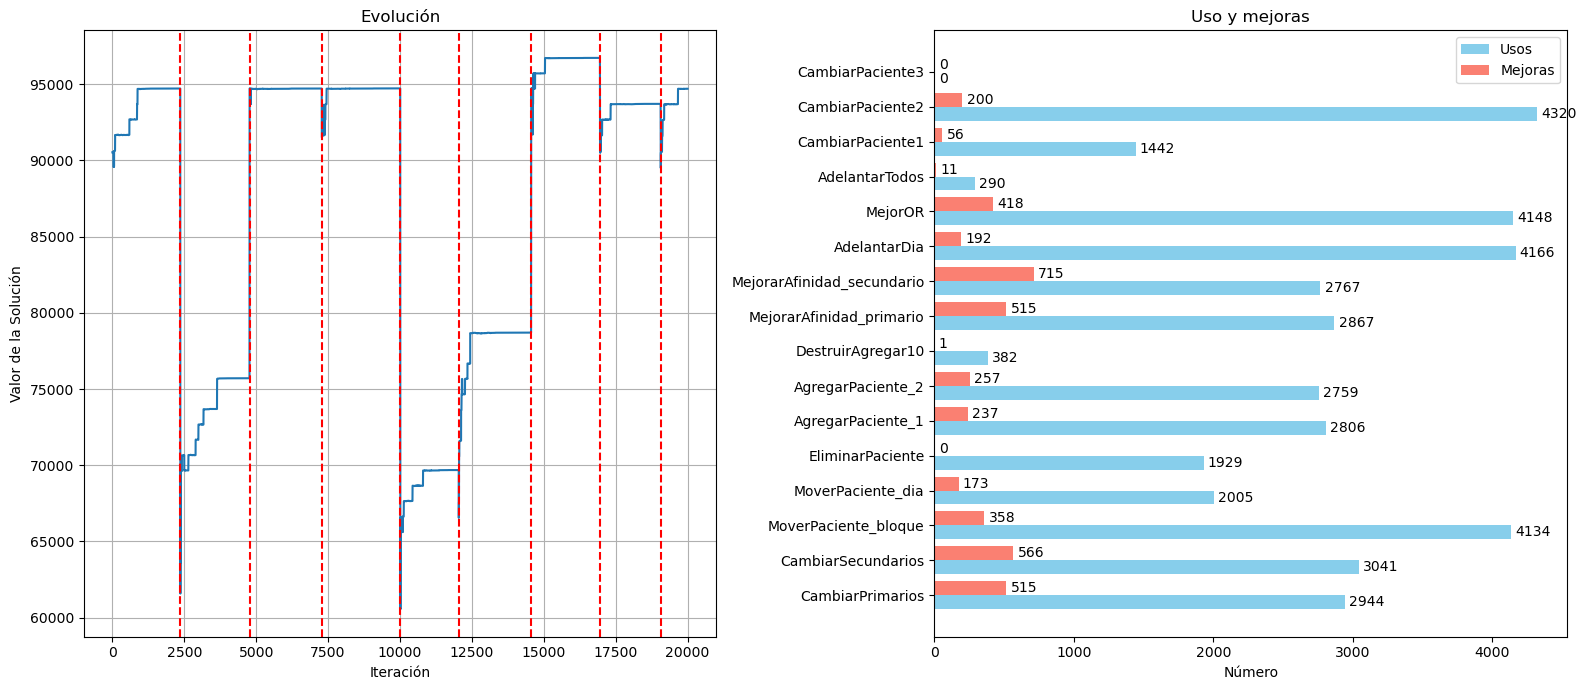

In [35]:
import copy
import random
import math
import sys
import importlib
from tqdm import tqdm

import perturbations
importlib.reload(perturbations)
from perturbations import (
    CambiarPrimarios,
    CambiarSecundarios,
    MoverPaciente_bloque,
    MoverPaciente_dia,
    EliminarPaciente,
    AgregarPaciente_1,
    AgregarPaciente_2,
    DestruirAgregar10
)

import localsearches
importlib.reload(localsearches)
from localsearches import (
    MejorarAfinidad_primario,
    MejorarAfinidad_secundario,
    AdelantarDia,
    MejorOR,
    AdelantarTodos,
    CambiarPaciente1,
    CambiarPaciente2,
    CambiarPaciente3
)

def compress(o, d, t):
    return o * nSlot * nDays + d * nSlot + t

def decompress(val):
    o = val // (nSlot*nDays)
    tmp = val % (nSlot*nDays)
    d = tmp // nSlot
    t = tmp % nSlot
    return o, d, t

def release_all(sol, usedMap):
    pac, pri, sec = sol
    for p in range(len(pac)):
        if pac[p] == -1:
            continue
        start = pac[p]
        dur = OT[p]
        o, d, t = decompress(start)
        s_main = pri.get(start, None)
        s_sec = sec.get(start, None)
        for b in range(dur):
            ds = (d, t + b)
            if s_main in usedMap and ds in usedMap[s_main]:
                usedMap[s_main].remove(ds)
            if s_sec in usedMap and ds in usedMap[s_sec]:
                usedMap[s_sec].remove(ds)

def assign_all(sol, usedMap):
    pac, pri, sec = sol
    for p in range(len(pac)):
        if pac[p] == -1:
            continue
        start = pac[p]
        dur = OT[p]
        o, d, t = decompress(start)
        s_main = pri.get(start, None)
        s_sec = sec.get(start, None)
        if s_main is None or s_sec is None:
            return False
        for b in range(dur):
            ds = (d, t + b)
            if ds in usedMap[s_main] or ds in usedMap[s_sec]:
                return False
        for b in range(dur):
            ds = (d, t + b)
            usedMap[s_main].add(ds)
            usedMap[s_sec].add(ds)
    return True

def check_feasible_change(old_sol, new_sol, timeUsedMap):
    if new_sol == old_sol:
        return True
    old_map = copy.deepcopy(timeUsedMap)
    release_all(old_sol, old_map)
    if not assign_all(new_sol, old_map):
        return False
    return True

def reparar(sol):
    pacientes, primarios, secundarios = sol
    def find_best_secondary(main_surg, blocks):
        best_sec = None
        best_val = float('-inf')
        for candidate_sec in second:
            if candidate_sec == main_surg:
                continue
            conflict = False
            for blk in blocks:
                if primarios.get(blk) == candidate_sec or secundarios.get(blk) == candidate_sec:
                    conflict = True
                    break
            if conflict:
                continue
            value = dfdisAffi.iloc[candidate_sec][main_surg + 1]
            if value > best_val:
                best_val = value
                best_sec = candidate_sec
        return best_sec

    for p_idx, start_block in enumerate(pacientes):
        if start_block == -1:
            continue
        dur = OT[p_idx]
        block_range = [start_block + b for b in range(dur)]
        main_s = primarios.get(start_block, None)
        sec_s  = secundarios.get(start_block, None)
        if main_s is None or sec_s is None:
            continue
        needs_fix = False
        if main_s == sec_s:
            needs_fix = True
        if not needs_fix:
            for blk in block_range:
                if primarios.get(blk) == sec_s:
                    needs_fix = True
                    break
                if secundarios.get(blk) == main_s:
                    needs_fix = True
                    break
        if needs_fix:
            new_sec = find_best_secondary(main_s, block_range)
            if new_sec is not None:
                for blk in block_range:
                    secundarios[blk] = new_sec

    return (pacientes, primarios, secundarios)

def destruir_OR(solution, OT, dictCosts, nSlot, nDays, room, day):
    surgeon_schedule = copy.deepcopy(solution[1]);
    or_schedule = copy.deepcopy(solution[2]);
    fichas = copy.deepcopy(solution[3]);
    pacientes, primarios, secundarios = copy.deepcopy(solution[0][0]), copy.deepcopy(solution[0][1]), copy.deepcopy(solution[0][2]);

    chosen_or = random.choice(room);
    chosen_day = random.choice(day);
    possible_times = [0, nSlot//2];
    possible_times = [t for t in possible_times if t < nSlot];
    chosen_time = random.choice(possible_times);
    patients_to_remove = set();
    start_slot = chosen_time;
    end_slot = min(chosen_time + nSlot // 2, nSlot);
    for t_aux in range(start_slot, end_slot):
        if t_aux < len(or_schedule[chosen_or][chosen_day]):
            p = or_schedule[chosen_or][chosen_day][t_aux];
            if p != -1:
                patients_to_remove.add(p);

    for p in patients_to_remove:
        if p not in pacientes or pacientes[p] == -1:
            continue
        start_block = pacientes[p];
        o_real, d_real, t_real = decompress(start_block);
        dur = OT[p];
        main_s = primarios[start_block];
        second_s = secundarios[start_block];
        cost_key = (main_s, second_s, start_block);
        cost = dictCosts[cost_key];

        for b in range(dur):
            current_block = start_block + b;
            current_t = t_real + b;
            if 0 <= o_real < len(or_schedule) and 0 <= d_real < len(or_schedule[o_real]) and 0 <= current_t < len(or_schedule[o_real][d_real]):
                 or_schedule[o_real][d_real][current_t] = -1
            if 0 <= main_s < len(surgeon_schedule) and 0 <= d_real < len(surgeon_schedule[main_s]) and 0 <= current_t < len(surgeon_schedule[main_s][d_real]):
                 if surgeon_schedule[main_s][d_real][current_t] == p:
                     surgeon_schedule[main_s][d_real][current_t] = -1
            if 0 <= second_s < len(surgeon_schedule) and 0 <= d_real < len(surgeon_schedule[second_s]) and 0 <= current_t < len(surgeon_schedule[second_s][d_real]):
                 if surgeon_schedule[second_s][d_real][current_t] == p:
                     surgeon_schedule[second_s][d_real][current_t] = -1

            primarios.pop(current_block, None)
            secundarios.pop(current_block, None)
        for d_aux in range(d_real, nDays):
            fichas_key = (main_s, d_aux)
            if fichas_key in fichas:
                 fichas[fichas_key] += cost;
        pacientes[p] = -1
    return ((pacientes, primarios, secundarios), surgeon_schedule, or_schedule, fichas)

def final_add_patients(solution, VERSION="A"):
    surgeon_schedule = copy.deepcopy(solution[1]);
    or_schedule = copy.deepcopy(solution[2]);
    fichas = copy.deepcopy(solution[3]);
    pacientes, primarios, secundarios = copy.deepcopy(solution[0][0]), copy.deepcopy(solution[0][1]), copy.deepcopy(solution[0][2]);

    unscheduled = [p for p in patient if pacientes[p] == -1];
    patient_sorted = sorted(unscheduled, key=lambda p: I[(p, 0)], reverse=True);

    def es_bloque_disponible(o, d_, t, dur):
        for b in range(dur):
            if or_schedule[o][d_][t + b] != -1:
                return False
        return True

    def cirujano_disponible(s, a, o, d_, t, dur):
        for b in range(dur):
            if surgeon_schedule[s][d_][t + b] != -1:
                return False
            if surgeon_schedule[a][d_][t + b] != -1:
                return False
        return True

    def asignar_paciente(p, s, a, o, d_, t, dur):
        start_block = compress(o, d_, t);
        pacientes[p] = start_block;

        for b in range(dur):
            blk = start_block + b;
            primarios[blk] = s;
            secundarios[blk] = a;

            or_schedule[o][d_][t + b] = p;
            surgeon_schedule[s][d_][t + b] = p;
            surgeon_schedule[a][d_][t + b] = p;

        cost = dictCosts[(s, a, start_block)];
        for d_aux in range(d_, len(day)):
            fichas[(s, d_aux)] -= cost;

    for p in patient_sorted:
        assigned = False;
        dur = OT[p];
        for o in room:
            for d_ in day:
                for t in range(nSlot - dur + 1):
                    if dur > 1:
                        if t < nSlot // 2 and (t + dur) > (nSlot // 2):
                            continue

                    feasible_aor = True;
                    if AOR[p][o][t][d_ % 5] != 1:
                        feasible_aor = False;
                    if not feasible_aor:
                        continue;

                    if not es_bloque_disponible(o, d_, t, dur):
                        continue;

                    valid_pairs = [];
                    for s in surgeon:
                        if SP[p][s] != 1:
                            continue;
                        for a in second:
                            if a != s and COIN[s][a] == 0:
                                valid_pairs.append((s, a));

                    for (s, a) in valid_pairs:
                        if cirujano_disponible(s, a, o, d_, t, dur):
                            if (dfdisAffi.iloc[a][s+1] >= level_affinity*(VERSION=="B") and
                                dfdisAffiDiario.iloc[d_ % 5][s+1] >= level_affinity*(VERSION=="B") and
                                dfdisAffiBloque.iloc[t // (nSlot // 2)][s+1] >= level_affinity*(VERSION=="B")):

                                checks = 0;
                                for i in range(num_ext):
                                    e = int(WhichExtra(o, t // 8, d_ % 5, i));
                                    if Ex[i][(s, e - 1)] >= level_affinity*(VERSION=="B"):
                                        checks += 1
                                if checks < num_ext*(VERSION=="B"):
                                    continue

                                start_block = compress(o, d_, t);
                                cost = dictCosts.get((s, a, start_block), 0);
                                enough_fichas = all(fichas[(s, d_aux)] >= cost*(VERSION=="C") for d_aux in range(d_, len(day)));
                                if not enough_fichas:
                                    continue;

                                asignar_paciente(p, s, a, o, d_, t, dur);
                                for d_aux in range(d_, len(day)):
                                    fichas[(s, d_aux)] -= cost;
                                assigned = True;
                                break
                        if assigned:
                            break
                    if assigned:
                        break
                if assigned:
                    break
            if assigned:
                break

    return ((pacientes, primarios, secundarios), surgeon_schedule, or_schedule, fichas);

def check_synchronized(sol, OT, last_p, last_s):
    fichas = [[nFichas * (d+1) for d in range(len(day))] for s in surgeon];

    surgeon_schedule_copy = copy.deepcopy(sol[1])
    or_schedule_copy = copy.deepcopy(sol[2])
    fichas_copy = copy.deepcopy(sol[3])
    pacientes_copy = copy.deepcopy(sol[0][0])
    primarios_copy = copy.deepcopy(sol[0][1])
    secundarios_copy = copy.deepcopy(sol[0][2])
    block_to_patient = {}
    for p_idx, blk_start in enumerate(pacientes_copy):
        if blk_start != -1:
            duration = OT[p_idx]
            for b in range(duration):
                blk = blk_start + b
                if blk in block_to_patient:
                    other_p = block_to_patient[blk]
                    msg = (f"Block {blk} is assigned to TWO patients: {p_idx} and {other_p}. MISMATCH => concurrency error. Last moves: {last_p}, {last_s}.")
                    #graficar_solucion(sol)
                    raise Exception(msg)
                block_to_patient[blk] = p_idx
    for blk in primarios_copy.keys():
        if blk not in block_to_patient:
            #graficar_solucion(sol)
            raise Exception(f"Block {blk} is in primarios but no patient claims it in `pacientes`. Last moves: {last_p}, {last_s}.")
    for blk in secundarios_copy.keys():
        if blk not in block_to_patient:
            #graficar_solucion(sol)
            raise Exception(f"Block {blk} is in secundarios but no patient claims it in `pacientes`. Last moves: {last_p}, {last_s}.")
    for p_idx, blk_start in enumerate(pacientes_copy):
        if blk_start != -1:
            duration = OT[p_idx]
            for b in range(duration):
                blk = blk_start + b
                if blk not in primarios_copy:
                    #graficar_solucion(sol)
                    raise Exception(f"Patient {p_idx} expects block {blk} in `primarios`, but not found. Last moves: {last_p}, {last_s}.")
                if blk not in secundarios_copy:
                    #graficar_solucion(sol)
                    raise Exception(f"Patient {p_idx} expects block {blk} in `secundarios`, but not found. Last moves: {last_p}, {last_s}.")
                
    try:
        pacientes_copy = sol[0][0]
        primarios_copy = sol[0][1]
        secundarios_copy = sol[0][2]
        fichas_copy = sol[3]
    except (IndexError, TypeError) as e:
        raise ValueError(f"Solution 'sol' has unexpected structure: {e}")
    daily_costs_incurred = {}

    for p_idx, start_blk in enumerate(pacientes_copy):
        if start_blk != -1:
            try:
                _, d_start, _ = decompress(start_blk)
            except Exception as e:
                raise Exception(f"Error decompressing start_block {start_blk} for patient {p_idx}: {e}. Last moves: {last_p}, {last_s}.")

            if start_blk not in primarios_copy:
                 raise Exception(f"Synchronization check failed: Patient {p_idx} starts at block {start_blk}, but block not in primarios_copy. Last moves: {last_p}, {last_s}.")
            if start_blk not in secundarios_copy:
                 raise Exception(f"Synchronization check failed: Patient {p_idx} starts at block {start_blk}, but block not in secundarios_copy. Last moves: {last_p}, {last_s}.")

            s_p = primarios_copy[start_blk]
            a_p = secundarios_copy[start_blk]

            # Get the cost
            cost_key = (s_p, a_p, start_blk)
            if cost_key not in dictCosts:
                raise Exception(f"Synchronization check failed: Cost not found in dictCosts for key {cost_key} (Patient {p_idx}, Block {start_blk}). Last moves: {last_p}, {last_s}.")
            cost = dictCosts[cost_key]

            # Add this cost to the primary surgeon's tally for the day the surgery starts
            cost_tuple = (s_p, d_start)
            daily_costs_incurred[cost_tuple] = daily_costs_incurred.get(cost_tuple, 0) + cost

    for s in surgeon:
        accumulated_cost = 0
        for d in range(nDays):
            cost_on_day_d = daily_costs_incurred.get((s, d), 0)
            accumulated_cost += cost_on_day_d

            initial_tokens_up_to_d = nFichas * (d + 1)
            expected_fichas = initial_tokens_up_to_d - accumulated_cost
            fichas_key = (s, d)
            if fichas_key not in fichas_copy:
                 raise Exception(f"Synchronization check failed: Missing key {fichas_key} in fichas_copy. Last moves: {last_p}, {last_s}.")

            actual_fichas = fichas_copy[fichas_key]
            if actual_fichas < 0:
                raise Exception(f"Synchronization check failed: Negative fichas detected for surgeon {s} on day {d}: {actual_fichas}. Last moves: {last_p}, {last_s}.")

            # Compare expected vs actual using tolerance
            if abs(expected_fichas - actual_fichas) > 0:
                msg = (f"Fichas synchronization error for Surgeon {s}, Day {d}. "
                       f"Expected: {expected_fichas:.4f} (Initial {initial_tokens_up_to_d} - Accumulated Cost {accumulated_cost:.4f}), "
                       f"Actual: {actual_fichas:.4f}. Difference: {expected_fichas - actual_fichas:.4f}. "
                       f"Last moves: {last_p}, {last_s}.")
                raise Exception(msg)
    return True

def metaheuristic(inicial, max_iter=50, destruct=200, temp_inicial=500.0, alpha=0.99, elite_size=5, prob_elite=0.3, synchro_check=True, hablar=True):
    global OT
    global dictCosts
    global SP

    initial_sol = inicial[0];
    surgeon_schedule = inicial[1];
    or_schedule = inicial[2];
    fichas = inicial[3];

    # [counts, improves, prob]
    metadata_pert = {"CambiarPrimarios": [0, 0, 15], "CambiarSecundarios": [0, 0, 15], "MoverPaciente_bloque": [0, 0, 20], "MoverPaciente_dia": [0, 0, 10],
              "EliminarPaciente": [0, 0, 10], "AgregarPaciente_1": [0, 0, 14], "AgregarPaciente_2": [0, 0, 14], "DestruirAgregar10": [0, 0, 2]};
    metadata_search = {"MejorarAfinidad_primario": [0, 0, 20], "MejorarAfinidad_secundario": [0, 0, 20],
                       "AdelantarDia": [0, 0, 29], "MejorOR": [0, 0, 29], "AdelantarTodos": [0, 0, 2], 
                       "CambiarPaciente1": [0, 0, 10], "CambiarPaciente2": [0, 0, 30], "CambiarPaciente3": [0, 0, 0]};
    
    lista_evaluacion = [];
    lista_iteracion = [];

    def Perturbar(sol, hablar=False):
        pert_probs = [v[2] for v in metadata_pert.values()];
        total_prob = sum(pert_probs);
        x = random.randint(0, total_prob - 1);
        cumulative = 0;
        for i, p in enumerate(pert_probs):
            cumulative += p
            if x < cumulative:
                perturbation = list(metadata_pert.keys())[i];
                metadata_pert[perturbation][0] += 1;
                funcion = f"{perturbation}(sol, surgeon, second, OT, I, SP, AOR, dictCosts, nSlot, nDays, hablar=hablar)";
                new_sol = eval(funcion);
                return new_sol, perturbation
        return sol, "NoOp"

    def BusquedaLocal(sol, hablar=False):
        search_probs = [v[2] for v in metadata_search.values()];
        total_prob = sum(search_probs);
        x = random.randint(0, total_prob - 1);
        cumulative = 0;
        for i, p in enumerate(search_probs):
            cumulative += p;
            if x < cumulative:
                localsearch = list(metadata_search.keys())[i];
                metadata_search[localsearch][0] += 1;
                funcion = f"{localsearch}(sol, surgeon, second, OT, I, SP, AOR, dictCosts, nSlot, nDays, hablar=hablar)";
                new_sol = eval(funcion);
                return new_sol, localsearch
        return sol, "NoOp"

    mejores_sols = [((initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy()), surgeon_schedule.copy(), or_schedule.copy(), fichas.copy())];
    best_solution = ((initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy()), surgeon_schedule.copy(), or_schedule.copy(), fichas.copy());
    best_sol = (best_solution[0][0].copy(), best_solution[0][1].copy(), best_solution[0][2].copy());
    best_cost = EvalAllORs(best_sol, VERSION=version);
    elite_pool = [(best_cost, copy.deepcopy(best_solution))];
    print(f"Costo inicial: {best_cost}") if hablar else None;
    #timeUsedMap = build_timeUsedMap(best_sol, nSlot, nDays);
    current_sol = ((best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy()), surgeon_schedule.copy(), or_schedule.copy(), fichas.copy());
    current_cost = best_cost;
    T = temp_inicial;
    r = 0;
    d_ = 0;
    reseteos = [];

    for i in tqdm(range(max_iter), desc="Progreso de la metaheurística..."):
        new_sol, last_p = Perturbar(current_sol, hablar=hablar);
        new_sol, last_s = BusquedaLocal(new_sol, hablar=hablar)
        new_cost = EvalAllORs(new_sol[0], VERSION=version)

        #if r % 60 == 0:
        #    graficar_solucion(new_sol[0]);
        print(f"Costo actual: {new_cost}") if hablar else None;

        delta = new_cost - current_cost;
        if delta > 0:
            metadata_pert[last_p][1] += 1;
            metadata_search[last_s][1] += 1;
            #current_sol = ((new_sol[0][0].copy(), new_sol[0][1].copy(), new_sol[0][2].copy()), new_sol[1].copy(), new_sol[2].copy(), new_sol[3].copy());
            current_sol = copy.deepcopy(new_sol);
            current_cost = new_cost;
            lista_evaluacion.append(current_cost);
            lista_iteracion.append(i);
            if new_cost > best_cost:
                metadata_pert[last_p][1] += 1;
                metadata_search[last_s][1] += 1;

                current_sol = copy.deepcopy(new_sol);
                current_cost = new_cost;

                best_cost = current_cost;
                best_solution = copy.deepcopy(current_sol);
                print(f"*** Nuevo Mejor Costo encontrado: {best_cost:.2f} at iter {i} ***") if hablar else None

                elite_pool.append((best_cost, copy.deepcopy(best_solution)));
                elite_pool.sort(key=lambda x: x[0], reverse=True);
                elite_pool = elite_pool[:elite_size];

                lista_evaluacion.append(current_cost);
                lista_iteracion.append(i);
            d_ = 0;
        else:
            prob_aceptacion = math.exp(delta / T)
            if random.random() < prob_aceptacion:
                #current_sol = ((new_sol[0][0].copy(), new_sol[0][1].copy(), new_sol[0][2].copy()), new_sol[1].copy(), new_sol[2].copy(), new_sol[3].copy());
                current_sol = copy.deepcopy(new_sol);
                current_cost = new_cost;
                lista_evaluacion.append(current_cost);
                lista_iteracion.append(i);
            else:
                d_ += 1;

        T *= alpha;
        '''
        if r % 50 == 0:
            current_sol = reparar(current_sol)
            current_cost = EvalAllORs(current_sol, VERSION=version)
            timeUsedMap = build_timeUsedMap(current_sol, nSlot, nDays)
        '''
        r += 1
        if d_ >= destruct:
            #best_sol = reparar(best_sol)
            mejores_sols.append((copy.deepcopy(current_sol)));
            #current_sol = destruir_OR(current_sol, OT, dictCosts, nSlot, nDays, room, day);
            #current_cost = EvalAllORs(current_sol[0], VERSION=version);
            if random.random() < prob_elite:
                _, chosen_elite_sol = random.choice(elite_pool);
                current_sol = copy.deepcopy(chosen_elite_sol);
                current_cost = EvalAllORs(current_sol[0], VERSION=version);
            else:
                pick = random.choice([1, 2, 3]);
                current_sol = GRASP(surgeon, second, patient, room, day, slot, AOR, I, dictCosts, nFichas, nSlot, SP, COIN, OT, alpha=0.2, modo=pick, VERSION="C", hablar=False);
                current_cost = EvalAllORs(current_sol[0], VERSION=version);
            T = temp_inicial;
            d_ = 0;
            reseteos.append(i);
        
        if synchro_check:
            check_synchronized(current_sol, OT, last_p, last_s);

    mejores_sols.append(best_sol);
    '''
    mejor_costo = float("-inf");
    mejor = None
    for m in mejores_sols:
        val = EvalAllORs(m[0], VERSION=version)
        if val > mejor_costo:
            mejor_costo = val
            mejor = m
    '''
    mejor_costo, mejor = elite_pool[0];

    #mejor = reparar(mejor)
    num_asignados_antes = sum(1 for p in mejor[0] if p != -1);
    mejor = final_add_patients(mejor, VERSION=version);
    check_synchronized(mejor, OT, last_p, last_s);
    #mejor = reparar(mejor)
    num_asignados_despues = sum(1 for p in mejor[0] if p != -1);
    print("Pacientes agregados en el intento final:", num_asignados_despues - num_asignados_antes)
    print("Último mejor costo:", EvalAllORs(mejor[0], VERSION=version)) if hablar else None;
    #graficar_solucion(mejor[0])
    return mejor, (lista_evaluacion, lista_iteracion, metadata_pert, metadata_search, reseteos)

#----------------------------------------------
random.seed(261)
#initial_sol = generar_solucion_inicial(VERSION=version, hablar=False)
sys.path.append("../algorithm");
import importlib
import initial_solutions
importlib.reload(initial_solutions);
from initial_solutions import GRASP

sol_inicial = GRASP(surgeon, second, patient, room, day, slot, AOR, I, dictCosts, nFichas, nSlot, SP, COIN, OT, alpha=0.25, modo=1, VERSION="C", hablar=False);

tiempo_inicial = time.time()
best_solution, stats = metaheuristic(sol_inicial, max_iter=20000, destruct=200, temp_inicial=930, alpha=0.995, elite_size=5, prob_elite=0.3, synchro_check=True, hablar=0)

print("Tiempo total:", round(time.time() - tiempo_inicial, 3), "segundos.")
print("Mejor costo:", EvalAllORs(best_solution[0], VERSION=version));
print("GAP:", str(1 - EvalAllORs(best_solution[0], VERSION=version) / bks)[:6]);

PlotStats(stats[0], stats[1], stats[2], stats[3], stats[4])

#### Copiar solución al portapapeles (para probar como solución inicial en LPM/CPM)

In [87]:
def copy_solution(sol):
    import pyperclip
    solution_string = "[";
    for s in sol:
        solution_string += str(s) + ", ";
    solution_string = solution_string[:-2];
    solution_string += "]";
    pyperclip.copy(solution_string);
    print(solution_string)

#### A ver si hay penalizaciones

In [22]:
print(EvalAllORs(best_solution[0], VERSION="C", hablar=True))

Score parcial OR=0: 9000
Score parcial OR=1: 12000
Score parcial OR=2: 34000
Score parcial OR=3: 34000
Puntaje final (después de restar fichas' sobrantes): 88860
Fichas restantes (por cirujano/día):
  Cirujano 0: [0]
  Cirujano 1: [16]
  Cirujano 2: [27]
  Cirujano 3: [48]
  Cirujano 4: [0]
  Cirujano 5: [0]
  Cirujano 6: [0]
  Cirujano 7: [0]
  Cirujano 8: [0]
  Cirujano 9: [48]
  Cirujano 10: [1]
  Cirujano 11: [0]
88860


#### Forzar adición

In [33]:
def test_force_add(sol, forced_tuple, VERSION="A"):
    p, s, a, o, d_, t = forced_tuple
    pacientes, primarios, secundarios = sol
    razones = []

    if pacientes[p] != -1:
        razones.append("El paciente ya está asignado a algún bloque")

    if s == a:
        razones.append("Cirujano principal y secundario no pueden ser el mismo")

    if SP[p][s] != 1:
        razones.append("El cirujano principal no es compatible con la especialidad del paciente")

    if COIN[s][a] != 0:
        razones.append("El cirujano principal no puede trabajar con el secundario (COIN != 0)")

    duracion_p = OT[p]
    if t + duracion_p > nSlot:
        razones.append("La duración excede el número de slots disponibles en ese día")

    for b in range(duracion_p):
        id_block = compress(o, d_, t + b)
        if id_block in primarios or id_block in secundarios:
            razones.append(f"El bloque {id_block} (día={d_}, OR={o}, t={t+b}) no está disponible")
            break

    # Verificar disponibilidad de cirujanos
    # Se construye un timeUsedMap temporal para revisarlo sin modificar el actual
    timeUsedMap_test = build_timeUsedMap(sol, nSlot, nDays)
    for b in range(duracion_p):
        if (d_, t + b) in timeUsedMap_test[s] or (d_, t + b) in timeUsedMap_test[a]:
            razones.append("El cirujano principal o secundario no está disponible en alguno de esos bloques")
            break

    if VERSION == "B":
        if dfdisAffi.iloc[a][s+1] < level_affinity:
            razones.append("Afinidad insuficiente (dfdisAffi)")
        if dfdisAffiDiario.iloc[d_ % 5][s+1] < level_affinity:
            razones.append("Afinidad insuficiente (dfdisAffiDiario)")
        if dfdisAffiBloque.iloc[t // (nSlot // 2)][s+1] < level_affinity:
            razones.append("Afinidad insuficiente (dfdisAffiBloque)")
        checks = 0
        for i in range(num_ext):
            e = int(WhichExtra(o, t // 8, d_ % 5, i))
            if Ex[i][(s, e - 1)] >= level_affinity:
                checks += 1
        if checks < num_ext:
            razones.append("Nivel de afinidad con el personal de apoyo insuficiente (Ex)")

    if VERSION == "C":
        cost = dictCosts.get((s, a, compress(o, d_, t)), 0)
        fichas = {(sx, dy): nFichas*(dy+1) for sx in surgeon for dy in day}
        for dy in range(d_, len(day)):
            if fichas[(s, dy)] < cost:
                razones.append("No quedan suficientes fichas para costear el paciente")
                break

    if len(razones) == 0:
        print("Sí se puede")
    else:
        print("No se puede debido a:")
        for r in razones:
            print("-", r)

test_force_add(best_solution, (9, 9, 6, 1, 1, 3), VERSION=version)

ValueError: too many values to unpack (expected 3)

In [197]:
dfPatient.iloc[10]

id                                    204164
fecha                                   1219
nombre          LUIS ARNALDO ARANEDA VIVEROS
edad                                      61
comuna                                 PUREN
espera                                   716
especialidad                   TRAUMATOLOGIA
tipo                                       1
prioridad                                  5
Name: 10, dtype: object

## Mostrar stats

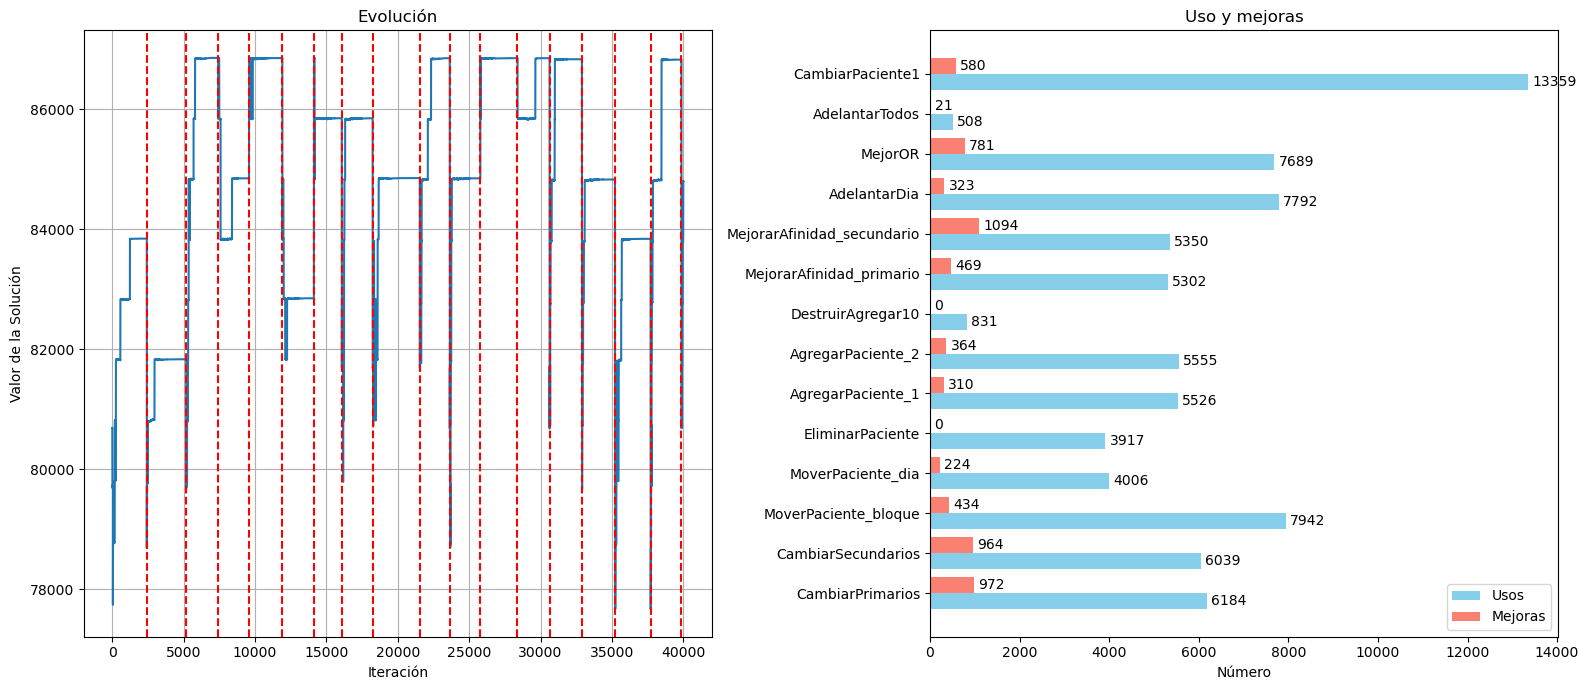

In [11]:
def PlotStats(lista_solucion: list, lista_iteracion: list, metadata_pert: dict, metadata_search: dict, reseteos: list):
    merged_data = {}
    merged_data.update(metadata_pert)
    merged_data.update(metadata_search)

    labels = list(merged_data.keys())
    usage_values = [v[0] for v in merged_data.values()]
    improvement_values = [v[1] for v in merged_data.values()]

    y = np.arange(len(labels))
    height = 0.4

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    ax1.plot(lista_iteracion, lista_solucion)
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Valor de la Solución')
    ax1.set_title('Evolución')
    ax1.grid(True)
    
    for x in reseteos:
        ax1.axvline(x, color='red', linestyle='--')

    bars1 = ax2.barh(y - height / 2, usage_values, height, label='Usos', color='skyblue')
    bars2 = ax2.barh(y + height / 2, improvement_values, height, label='Mejoras', color='salmon')

    ax2.set_xlabel('Número')
    ax2.set_title('Uso y mejoras')
    ax2.set_yticks(y)
    ax2.set_yticklabels(labels)
    ax2.legend()

    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            ax2.annotate('{}'.format(width),
                         xy=(width, bar.get_y() + bar.get_height() / 2),
                         xytext=(3, 0),
                         textcoords="offset points",
                         ha='left', va='center')
    
    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.show()

PlotStats(stats[0], stats[1], stats[2], stats[3], stats[4])

## Mostrar schedule

In [16]:
print(EvalAllORs(best_solution, hablar=True))
#print(best_solution)
graficar_solucion(best_solution)

Score para OR 0: 39000.

Score para OR 1: 60000.

Score para OR 2: 104000.

Score para OR 3: 76000.

Fichas: [[-20, -45, -36, -14, -61], [40, 80, 120, 160, 102], [33, 50, 90, 130, 155], [40, 24, 50, 90, 78], [20, -3, 13, 14, 54], [-8, 32, 40, 27, 67], [1, 2, -22, -28, -1], [10, 50, 17, 1, 41], [2, 0, 40, 44, 69], [40, 35, 19, 11, 0]]
236292
OR 0:
         Día 0       Día 1       Día 2       Día 3       Día 4
T0   (0, 6, 1)         NaN         NaN   (6, 6, 1)   (9, 0, 1)
T1   (0, 6, 1)  (12, 4, 0)  (66, 6, 3)   (7, 0, 1)  (60, 6, 1)
T2   (1, 6, 1)  (13, 4, 0)   (5, 0, 1)   (8, 0, 1)  (60, 6, 1)
T3   (2, 6, 1)  (14, 4, 0)   (5, 0, 1)   (8, 0, 1)  (60, 6, 1)
T4  (10, 4, 0)  (15, 4, 0)  (40, 7, 8)   (8, 0, 1)  (44, 1, 7)
T5  (10, 4, 0)  (16, 4, 0)  (41, 7, 8)  (19, 4, 1)  (45, 1, 7)
T6  (10, 4, 0)  (17, 4, 0)  (42, 7, 8)  (70, 4, 2)  (46, 1, 7)
T7  (11, 4, 0)  (18, 4, 0)  (43, 7, 8)  (71, 4, 9)  (47, 1, 6)


OR 1:
         Día 0       Día 1        Día 2        Día 3        Día 4
T0  (61, 0

## Graficar solución (LPM)

In [80]:
pacientes = [94, 44, 45, 47, 40, 42, 0, 46, 1, 41, 134, 133, 132, 128, 122, 130, 145, 120, 123, 121, 81, 82, 80, 87, 83, 85, 124, 126, 127, 125, 23, 139]
primarios = {94: 0, 95: 0, 44: 6, 45: 0, 47: 6, 40: 6, 42: 6, 43: 6, 0: 0, 46: 6, 1: 0, 2: 0, 3: 0, 41: 6, 134: 2, 133: 8, 132: 2, 128: 8, 129: 8, 122: 8, 130: 8, 131: 8, 145: 8, 146: 8, 147: 8, 120: 8, 123: 2, 121: 8, 81: 5, 82: 5, 80: 5, 87: 5, 83: 5, 85: 5, 124: 7, 126: 7, 127: 1, 125: 7, 23: 7, 139: 7}
secundarios = {94: 5, 95: 5, 44: 8, 45: 5, 47: 0, 40: 4, 42: 0, 43: 0, 0: 1, 46: 0, 1: 5, 2: 5, 3: 5, 41: 3, 134: 4, 133: 4, 132: 5, 128: 5, 129: 5, 122: 2, 130: 2, 131: 2, 145: 2, 146: 2, 147: 2, 120: 0, 123: 4, 121: 2, 81: 8, 82: 4, 80: 9, 87: 3, 83: 8, 85: 1, 124: 9, 126: 3, 127: 6, 125: 6, 23: 9, 139: 9}

print(EvalAllORs((pacientes, primarios, secundarios), hablar=True))
graficar_solucion((pacientes, primarios, secundarios))

KeyError: (6, 8, 44)

# GP

In [ ]:
asignP = [-1] * len(patient);
asignS = [[] for _ in range(len(surgeon))];
asignA = [[] for _ in range(len(second))];

pset = gp.PrimitiveSet("MAIN", 0);

def mostrar(text: str):
    if hablar:
        print(text);
def CirujanosCompatibles(sol: tuple, p:int, primario: bool=True) -> list:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    t = pacientes[p];
    compatible_surgeons = [];
    if primario:
        compatible_surgeons_set = {s for s in surgeon if SP[p][s] == 1};
        for s in compatible_surgeons_set:
            compatible = True;
            for b in range(dur):
                current_block = t + b;
                current_day_time = decompress(current_block)[1:];
                if any(decompress(block)[1:] == current_day_time and primarios.get(block) == s for block in primarios):
                    compatible = False;
                    break
            if compatible:
                compatible_surgeons.append(s);
    else:
        for a in second:
            compatible = True;
            for b in range(dur):
                current_block = t + b;
                current_day_time = decompress(current_block)[1:];
                if any(decompress(block)[1:] == current_day_time and secundarios.get(block) == a for block in primarios):
                    compatible = False;
                    break
            if compatible:
                compatible_surgeons.append(a);            
    return compatible_surgeons
def EncontrarEspacio(sol: tuple, p: int, o: int, d:int) -> list:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    espacios_disponibles = [];
    for t in range(nSlot - dur + 1):
        espacio_continuo = True;
        for b in range(dur):
            current_block = compress(o, d, t + b)
            if primarios.get(current_block) is not None or AOR[p][o][t + b][d] != 1:
                espacio_continuo = False;
                break
        if espacio_continuo:
            espacios_disponibles.append(compress(o, d, t));
    return espacios_disponibles
def MoverPaciente(sol: tuple, p: int, desde:int, hasta:int) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    prim_disp = [s for s in surgeon if SP[p][s] == 1];
    sec_disp = [a for a in second];
    if not prim_disp or not sec_disp:
        print("No hay cirujanos disponibles para el paciente.");
        return (pacientes, primarios, secundarios)
    espacio_continuo = True;
    for b in range(dur):
        current_block = hasta + b
        if current_block in primarios or current_block in secundarios:
            espacio_continuo = False;
            break;
    if not espacio_continuo:
        print("No hay espacio disponible para mover el paciente.")
        return (pacientes, primarios, secundarios)

    pacientes[p] = hasta;
    for b in range(dur):
        del primarios[desde + b];
        del secundarios[desde + b];
        current_block = hasta + b;
        primarios[current_block] = random.choice(prim_disp);
        secundarios[current_block] = random.choice(sec_disp);
    return (pacientes, primarios, secundarios)

#TERMINALES
#ILS: Pertubaciones
def CambiarPrimarios(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p1, p2 = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 2);
    t1, t2 = pacientes[p1], pacientes[p2];
    cir1, cir2 = primarios[t1], primarios[t2];
    dur1, dur2 = int(OT[p1]), int(OT[p2]);
    mostrar(f"Moviendo cirujano primario {cir1} desde {t1} hasta {t2}...");
    for t in range(dur1):
        primarios[t1 + t] = cir2;
    mostrar(f"Moviendo cirujano primario {cir2} desde {t2} hasta {t1}...");
    for t in range(dur2):
        primarios[t2 + t] = cir1;
    mostrar("Primarios intercambiados.");
    return True

def CambiarSecundarios(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p1, p2 = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 2);
    t1, t2 = pacientes[p1], pacientes[p2];
    cir1, cir2 = secundarios[t1], secundarios[t2];
    dur1, dur2 = int(OT[p1]), int(OT[p2]);
    mostrar(f"Moviendo cirujano secundario {cir1} desde {t1} hasta {t2}...");
    for t in range(dur1):
        secundarios[t1 + t] = cir2;
    mostrar(f"Moviendo cirujano secundario {cir2} desde {t2} hasta {t1}...");
    for t in range(dur2):
        secundarios[t2 + t] = cir1;
    mostrar("Secundarios intercambiados.");
    return True

def MoverPaciente_bloque(sol: tuple) -> tuple:
    pac_aux, prim_aux, sec_aux = sol[0].copy(), sol[1].copy(), sol[2].copy();
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    prim = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    o, d, t = decompress(pacientes[p]);
    dur = OT[p];
    mov = random.choice([-1, 1]);
    if t + mov >= 1 and t + mov < nSlot - dur:
        if mov == -1:
            if pacientes[p] - 1 in primarios:
                mostrar(f"Paciente {p} (duración {dur}) no pudo moverse (bloque {t}).");
                return False
            else:
                del primarios[pacientes[p] + dur - 1];
                del secundarios[pacientes[p] + dur - 1];
                primarios[pacientes[p] - 1] = prim;
                secundarios[pacientes[p] - 1] = sec;
                pacientes[p] = compress(o, d, t+mov);
                mostrar(f"Paciente {p} (duración {dur}) movido de bloque {t} a bloque {t+mov}.");
                return True
        else:
            if pacientes[p] + dur in primarios:
                mostrar(f"Paciente {p} (duración {dur}) no pudo moverse (bloque {t}).");
                return False
            else:
                del primarios[pacientes[p]];
                del secundarios[pacientes[p]];
                primarios[pacientes[p] + dur] = prim;
                secundarios[pacientes[p] + dur] = sec;
                pacientes[p] = compress(o, d, t+mov);
                mostrar(f"Paciente {p} (duración {dur}) movido de bloque {t} a bloque {t+mov}.");
                return True
    mostrar(f"Paciente {p} (duración {dur}) no pudo moverse desde bloque {t} hasta bloque {t+mov}.");
    return False

def MoverPaciente_dia(sol: tuple) -> tuple:
    pac_aux, prim_aux, sec_aux = sol[0].copy(), sol[1].copy(), sol[2].copy();
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    prim = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    o, d, t = decompress(pacientes[p]);
    dur = int(OT[p]);
    mov = random.choice([-1, 1]);
    if d + mov >= 1 and d + mov < nDays:
        for b in range(dur):
            bloque = compress(o, d+mov, t+b)
            if bloque in primarios:
                mostrar(f"Paciente {p} no pudo moverse desde día {d} hasta día {d+mov}.");
                return False
            else:
                del primarios[compress(o, d, t+b)];
                primarios[bloque] = prim;
                del secundarios[compress(o, d, t+b)];
                secundarios[bloque] = sec;
        pacientes[p] = compress(o, d+mov, t);
        mostrar(f"Paciente {p} movido desde día {d} hasta día {d+mov}.");
        return True
    mostrar(f"Paciente {p} no pudo moverse desde día {d} hasta día {d+mov}.");
    return False

def EliminarPaciente(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay pacientes asignados.");
        return False
    dur = int(OT[p]);
    for b in range(dur):
        del primarios[pacientes[p] + b];
        del secundarios[pacientes[p] + b];
    pacientes[p] = -1;
    mostrar(f"Paciente {p} eliminado.");
    return True

def AgregarPaciente(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente == -1], 1)[0];
    except:
        mostrar("No hay pacientes para agregar.");
        return False
    dur = int(OT[p]);
    c = compress(o, d, t);
    disponible = [c for o in room for t in slot for d in day if AOR[p][o][t][d] == 1 and c not in primarios];
    if len(disponible) < dur:
        mostrar("No hay espacio para asignar.");
        return False
    disponible.sort();
    pos = random.choice(range(len(disponible)));
    val = disponible[pos];
    prim_disp = [s for s in surgeon if all(decompress(c)[1:] != decompress(val + b)[1:] for c in primarios if primarios[c] == s)];
    sec_disp = [a for a in second];
    if not prim_disp or not sec_disp:
        mostrar("No hay cirujanos disponibles.")
        return False
    pacientes[p] = val;
    for b in range(dur):
        primarios[val + b] = random.choice(prim_disp);
        secundarios[val + b] = random.choice(sec_disp);
    return True

#ILS: Búsquedas Locales    
def MejorarAfinidad_primario(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    cir = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    costo = dictCosts[(cir, sec, pacientes[p])];
    comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
    if len(comp) == 0:
        mostrar("No hay primarios disponibles para cambio.");
        return False
    best = cir;
    for s in comp:
        if s != sec:
            if dictCosts[(s, sec, pacientes[p])] >= costo:
                costo = dictCosts[(s, sec, pacientes[p])];
                best = s;
    for b in range(OT[p]):
        primarios[pacientes[p] + b] = best;
    mostrar(f"Por afinidad, se ha cambiado al cirujano primario {cir} por el cirujano primario {best}.");
    return True

def MejorarAfinidad_secundario(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    cir = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    costo = dictCosts[(cir, sec, pacientes[p])];
    comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
    if len(comp) == 0:
        mostrar("No hay secundarios disponibles para cambio.");
        return False
    best = sec;
    for a in comp:
        if a != cir:
            if dictCosts[(cir, a, pacientes[p])] >= costo:
                costo = dictCosts[(cir, a, pacientes[p])];
                best = a;
    for b in range(OT[p]):
        secundarios[pacientes[p] + b] = best;
    mostrar(f"Por afinidad, se ha cambiado al cirujano secundario {sec} por el cirujano secundario {best}.");
    return True

def AdelantarDia(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    o, d, t = decompress(pacientes[p]);
    for dia in range(d):
        disp = EncontrarEspacio((pacientes, primarios, secundarios), p, o, dia);
        if len(disp) > 0: 
            dur = OT[p];
            for b in range(dur):
                current_block = pacientes[p] + b
                if current_block in primarios:
                    del primarios[current_block];
                if current_block in secundarios:
                    del secundarios[current_block];
            pacientes[p] = disp[0];
            prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p);
            sec_disp = [a for a in second];
            if not prim_disp or not sec_disp:
                mostrar("No hay cirujanos disponibles para el paciente a esa hora.")
                return False
            prim = random.choice(prim_disp);
            sec = random.choice(sec_disp);
            for b in range(dur):
                current_block = disp[0] + b
                primarios[current_block] = prim;
                secundarios[current_block] = sec;
            mostrar(f"Paciente {p} movido desce  el día {d} hasta el día {dia}.");
            return True
    mostrar("No se encontró espacio disponible en días anteriores.")
    return False

pset.addTerminal(CambiarPrimarios, name="CambiarPrimario");
pset.addTerminal(CambiarSecundarios, name="CambiarSecundario");
pset.addTerminal(MoverPaciente_bloque, name="MoverPacienteB");
pset.addTerminal(MoverPaciente_dia, name="MoverPacienteD");
pset.addTerminal(AgregarPaciente, name="AgregarPaciente");
pset.addTerminal(EliminarPaciente, name="EliminarPaciente");
pset.addTerminal(MejorarAfinidad_primario, name="MejorarAfinidadP");
pset.addTerminal(MejorarAfinidad_secundario, name="MejorarAfinidadS");
pset.addTerminal(AdelantarDia, name="AdelantarDia");

#PRIMITIVAS

def if_then_else(condition, out1, out2):
    try:
        out1() if condition() else out2();
        return True
    except TypeError:
        return True

def And(out1, out2):
    try:
        oli = out1() and out2()
        return oli
    except TypeError:
        return True

def Or(out1, out2):
    try:
        oli = out1() or out2()
        return oli
    except TypeError:
        return True
    
def While(condition, action):
    i = 0;
    try:
        oli = condition();
        while oli and i < 20:
            action(); 
            if not condition():
                break;
            i += 1;
        return True
    except TypeError:
        return True
    
#def sequential2
#def sequential3

pset.addPrimitive(if_then_else, 3);
pset.addPrimitive(And, 2);
pset.addPrimitive(Or, 2);
pset.addPrimitive(While, 2);

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalAllORs(sol, hablar=False):
    pacientes, primarios, secundarios = sol;
    puntaje = 0;
    for or_id in room:
        points = evalSchedule(pacientes, primarios, secundarios, or_id, hablar);
        puntaje += points;
        if hablar:
            print(f"Score para OR {or_id}: {points}.\n");
    return puntaje

def evalSchedule(pacientes, primarios, secundarios, or_id, hablar=False):
    bloques_por_paciente = {};
    penalizaciones = 0;
    registros = set();
    fichas = [[int(instancia[INS][4]) * (d+1) for d in range(nDays)] for s in surgeon];
    score = 0;
    for p in range(len(pacientes)):
        if pacientes[p] != -1:
            o_p, d_p, t_p = decompress(pacientes[p])
            if o_p == or_id:
                duracion = OT[p];
                prioridad_paciente = I[(p, d_p)];
                if p not in bloques_por_paciente:
                    bloques_por_paciente[p] = [];
                    score += 1000 * prioridad_paciente;
                for b in range(int(duracion)):
                    t_actual = t_p + b;
                    bloque_horario = compress(o_p, d_p, t_actual);
                    bloques_por_paciente[p].append(bloque_horario);

                    #s = [prim for prim, asign in enumerate(primarios) if bloque_horario in asign][0];
                    #a = [sec for sec, asign in enumerate(secundarios) if bloque_horario in asign][0];
                    
                    s = primarios[bloque_horario];
                    a = secundarios[bloque_horario];
                    
                    for d in range(d_p, nDays):
                        fichas[s][d] -= dictCosts[(s, a, bloque_horario)];

                    if SP[p][s] != 1:
                        penalizaciones += 10;  #Penalización si la especialidad no coincide
                        if hablar:
                            print(f"Penalización: Especialidad del cirujano {s} no coincide para paciente {p} en OR {or_id}.");
                    if s == a:
                        penalizaciones += 10;  #Penalización por ser mismo cirujano principal y secundario
                        if hablar:
                            print(f"Penalización: Cirujano principal y secundario son la misma persona para paciente {p} en OR {or_id}.");
                    # if (s, bloque_horario) in registros:
                    #     penalizaciones += 50;  #Penalización por asignar a un mismo bloque horario
                    #     if hablar:
                    #         print(f"Penalización: Cirujano {s} reasignado en el mismo bloque {bloque_horario} en OR {or_id}.");
                    #registros.add((s, bloque_horario));

    for paciente_id, bloques in bloques_por_paciente.items():
        bloques.sort();
        duracion = OT[paciente_id];
        if len(bloques) != duracion:
            penalizaciones += 50 * len(bloques)  #Penalizar por cada bloque asignado mal
            if hablar:
                print(f"Penalización: Duración incorrecta para paciente {paciente_id} en OR {or_id}. Esperado: {duracion}, Obtenido: {len(bloques)}.")
        if not all(bloques[i] + 1 == bloques[i + 1] for i in range(len(bloques) - 1)):
            penalizaciones += 100 * len(bloques)  #Penalización por cada bloque no consecutivo
            if hablar:
                print(f"Penalización: Bloques no consecutivos para paciente {paciente_id} en OR {or_id}.");
    score -= 10 * penalizaciones  #Restar las penalizaciones del score total
    for d in range(nDays):
        for s in surgeon:
            score -= fichas[s][d] * nDays//(d+1);
    if hablar:
        print(f"Score final para OR {or_id}: {score}");
    return score


toolbox.register("evaluate", evalPlanificacion);
toolbox.register("select", tools.selTournament, tournsize=3);
toolbox.register("mate", gp.cxOnePoint);
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset);
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));

# Función principal para ejecutar el algoritmo genético
def main():
    random.seed(258)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 50, stats=mstats, halloffame=hof, verbose=True)
    best_ind = tools.selBest(pop, 1)[0]
    print("Mejor individuo es:", best_ind)
    print("Con un fitness de:", best_ind.fitness.values)

    return pop, log, hof

if __name__ == "__main__":
    main()

In [79]:
x = 2;
print("Hola") if x == 1 else None;

%pip install requests


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Unrelated

In [ ]:
# debug_scrape_expatistan.py
# Created/Modified files during execution: None

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm

def scrape_and_build_dataframe():
    base_url = "https://www.expatistan.com"
    main_url = f"{base_url}/cost-of-living/all-cities"

    print(f"Scraping the main page: {main_url}")
    try:
        response = requests.get(main_url)
    except requests.exceptions.RequestException as e:
        print(f"Connection issue: {e}")
        return pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    print(f"Response status code: {response.status_code}")
    if not response.ok:
        print(f"Failed to retrieve {main_url}")
        return pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    soup = BeautifulSoup(response.text, "html.parser")

    # Find all repeated div blocks with class="three-columns" and id="all-cities"
    div_blocks = soup.find_all("div", class_="three-columns", id="all-cities")
    if not div_blocks:
        print("Could not find any 'div' with id='all-cities' and class='three-columns'.")
        return pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    # This will store up to three (country, city) pairs
    country_city_pairs = []

    # For each block, parse the <h3><a> for the COUNTRY, then <ul><li><a> for the CITY
    for block in div_blocks:
        h3_tag = block.find("h3")
        if not h3_tag:
            continue

        country_a = h3_tag.find("a")
        if not country_a:
            continue

        # This is the country text (e.g. "Afghanistan", "Aland Islands", "Albania")
        country_text = country_a.get_text(strip=True)

        ul_tag = block.find("ul")
        if not ul_tag:
            continue

        # For each <li> -> <a>, we get a city link
        li_tags = ul_tag.find_all("li")
        for li_tag in li_tags:
            city_a = li_tag.find("a")
            if not city_a:
                continue

            city_text = city_a.get_text(strip=True)  # e.g. "Kabul", "Mariehamn", "Durrës"

            # Store the pair of (country, city)
            country_city_pairs.append((country_text, city_text))

            # Stop collecting if we already have 3
            if len(country_city_pairs) == 3:
                break
        if len(country_city_pairs) == 3:
            break

    print(f"Number of (country, city) anchors found: {len(country_city_pairs)}")
    if not country_city_pairs:
        print("No city anchors found!")
        return pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    # Prepare the final DataFrame
    df = pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    # Regex to remove "Cost of living in" from the start of <h1> text
    heading_pattern = re.compile(r"(?i)^\s*cost of living in\s*")

    # Now scrape each city page to get costs
    for country_name, city_name in tqdm(country_city_pairs, desc="Scraping cities"):
        # Build the slug for the city page
        city_slug = re.sub(r"\s+", "-", city_name.strip().lower())
        city_url = f"{base_url}/cost-of-living/{city_slug}?currency=EUR"

        print(f"\nScraping cost data for city = '{city_name}' in country = '{country_name}'")
        print(f"Constructed city URL = {city_url}")

        try:
            city_resp = requests.get(city_url)
        except requests.exceptions.RequestException as e:
            print(f"Connection issue for {city_name}: {e}")
            # Append a row with missing cost data
            df.loc[len(df)] = [country_name, city_name, None, None]
            continue

        print(f"City page response code: {city_resp.status_code}")
        if not city_resp.ok:
            print(f"Warning: Could not retrieve page for {city_name}.")
            df.loc[len(df)] = [country_name, city_name, None, None]
            continue

        city_soup = BeautifulSoup(city_resp.text, "html.parser")

        # Attempt to parse city/country from <h1> to confirm
        h1_tag = city_soup.find("h1")
        parsed_city = city_name
        parsed_country = country_name

        if h1_tag:
            h1_text = h1_tag.get_text(strip=True)
            # e.g. "Cost of living in Kabul, Afghanistan"
            city_country_text = heading_pattern.sub("", h1_text).strip()
            parts = [p.strip() for p in city_country_text.split(",")]
            if len(parts) == 2:
                parsed_city, parsed_country = parts
            elif parts:
                parsed_city = parts[0]

        print(f"  -> Confirmed City: {parsed_city}, Confirmed Country: {parsed_country}")

        # Collect <li class="key-point"> cost-of-living data
        li_elements = city_soup.find_all("li", class_="key-point")
        print(f"  -> Found {len(li_elements)} key-point elements.")

        family_of_four = None
        single_person = None

        for li_el in li_elements:
            text_li = li_el.get_text(separator=" ", strip=True).lower()
            price_span = li_el.find("span", class_="price")
            if not price_span:
                continue

            raw_price = price_span.get_text(strip=True)
            # Peel off everything after "(" to keep only the EUR portion
            raw_eur_part = raw_price.split("(")[0].strip()
            # Remove '€' and commas
            raw_eur_part = raw_eur_part.replace("€", "").replace(",", "")

            if "family of four estimated monthly costs" in text_li:
                family_of_four = raw_eur_part
                print(f"    -> Found family_of_four cost: {raw_price} => {family_of_four}")
            elif "single person estimated monthly costs" in text_li:
                single_person = raw_eur_part
                print(f"    -> Found single_person cost: {raw_price} => {single_person}")

        # Title-case country/city names for data neatness
        parsed_country = parsed_country.title() if parsed_country else None
        parsed_city = parsed_city.title() if parsed_city else None

        df.loc[len(df)] = [
            parsed_country,
            parsed_city,
            family_of_four,
            single_person
        ]

    return df

if __name__ == "__main__":
    df_result = scrape_and_build_dataframe()
    print("\nFINAL DATAFRAME:")
    print(df_result)

Scraping the main page: https://www.expatistan.com/cost-of-living/all-cities
Connection issue: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

FINAL DATAFRAME:
Empty DataFrame
Columns: [Country, City, Family_of_Four, Single]
Index: []


In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import unicodedata
import pandas as pd
import time
import random
import re
from tqdm import tqdm

def remove_accents(input_str: str) -> str:
    """
    Not strictly needed if we rely on the direct city link, but kept for potential use.
    Converts accented characters to their unaccented equivalents.
    """
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def random_delay(mean=3.0, spread=2.0):
    """
    Generate a random delay in seconds around the given mean.
    Ensures a minimum delay of 0.5 seconds.
    """
    return max(0.5, random.uniform(mean - spread, mean + spread))

def is_test_page(page_text: str) -> bool:
    """
    Detect if the page text indicates a captcha/verification page or unknown city.
    """
    text_lower = page_text.lower()
    if "please complete this test" in text_lower or "we are not sure what city is" in text_lower:
        return True
    return False

def get_page_with_retry(url: str, session: requests.Session, max_retries: int = 2):
    """
    Attempts to fetch the given URL up to max_retries times.
    Returns the response if successful, None otherwise.
    """
    attempts = 0
    while attempts < max_retries:
        time.sleep(random_delay())
        attempts += 1
        try:
            resp = session.get(url)
            if resp.ok:
                soup_text = BeautifulSoup(resp.text, "html.parser").get_text(separator=" ", strip=True)
                # Check for anti-bot / "test" pages
                if not is_test_page(soup_text):
                    return resp
            # Fall through and retry if either resp not ok or test page
        except requests.exceptions.RequestException:
            pass
    return None

def scrape_and_build_dataframe():
    base_url = "https://www.expatistan.com"
    main_url = urljoin(base_url, "/cost-of-living/all-cities")

    # Create a session with a browser-like User-Agent
    session = requests.Session()
    session.headers.update({
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/103.0.0.0 Safari/537.36"
        )
    })

    main_resp = get_page_with_retry(main_url, session, max_retries=2)
    if not main_resp:
        # Could not fetch main page - return empty DataFrame
        return pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    soup = BeautifulSoup(main_resp.text, "html.parser")
    city_blocks = soup.find_all("div", class_="three-columns", id="all-cities")

    # Gather all (country, city-text, city-href)
    city_links = []
    for block in city_blocks:
        h3_tag = block.find("h3")
        if not h3_tag:
            continue
        country_a = h3_tag.find("a")
        if not country_a:
            continue

        country_text = country_a.get_text(strip=True)

        ul_tag = block.find("ul")
        if not ul_tag:
            continue
        li_tags = ul_tag.find_all("li")
        for li_tag in li_tags:
            a_tag = li_tag.find("a")
            if a_tag:
                city_name = a_tag.get_text(strip=True)
                city_href = a_tag.get("href", "")
                # Convert relative path to absolute
                full_city_url = city_href if city_href.startswith("http") else urljoin(base_url, city_href)
                city_links.append((country_text, city_name, full_city_url))

    # Prepare DataFrame
    df = pd.DataFrame(columns=["Country", "City", "Family_of_Four", "Single"])

    # Pattern to remove "Cost of living in" from <h1>
    heading_pattern = re.compile(r"(?i)^\s*cost of living in\s*")

    for (country_text, city_text, city_url) in tqdm(city_links, desc="Scraping cities"):
        city_resp = get_page_with_retry(city_url + "?currency=EUR", session, max_retries=2)
        if not city_resp:
            df.loc[len(df)] = [f"{country_text}", f"{city_text}", None, None]
            df.to_csv("expatistan_progress.csv", index=False)
            continue

        city_soup = BeautifulSoup(city_resp.text, "html.parser")
        h1_tag = city_soup.find("h1")

        parsed_city = city_text
        parsed_country = country_text
        if h1_tag:
            h1_text = h1_tag.get_text(strip=True)
            # Remove "Cost of living in ..."
            city_country_text = heading_pattern.sub("", h1_text).strip()
            parts = [p.strip() for p in city_country_text.split(",")]
            if len(parts) == 2:
                parsed_city, parsed_country = parts
            elif parts:
                parsed_city = parts[0]

        li_elements = city_soup.find_all("li", class_="key-point")
        family_of_four = None
        single_person = None

        for li_el in li_elements:
            text_li = li_el.get_text(separator=" ", strip=True).lower()
            price_span = li_el.find("span", class_="price")
            if not price_span:
                continue

            raw_price = price_span.get_text(strip=True)
            # Peel off anything after '('
            raw_eur_part = raw_price.split("(")[0].strip()
            raw_eur_part = raw_eur_part.replace("€", "").replace(",", "")
            if "family of four estimated monthly costs" in text_li:
                family_of_four = raw_eur_part
            elif "single person estimated monthly costs" in text_li:
                single_person = raw_eur_part

        parsed_country = parsed_country.title() if parsed_country else None
        parsed_city = parsed_city.title() if parsed_city else None

        df.loc[len(df)] = [parsed_country, parsed_city, family_of_four, single_person]
        df.to_csv("expatistan_progress.csv", index=False)

    return df

if __name__ == "__main__":
    result_df = scrape_and_build_dataframe()
    # If you want the final DataFrame printed to console, uncomment:
    # print("\nFINAL DATAFRAME:")
    print(result_df.head())

Scraping cities: 100%|██████████| 3037/3037 [3:53:15<00:00,  4.61s/it]  

         Country       City Family_of_Four Single
0    Afghanistan      Kabul           1737    786
1  Aland Islands  Mariehamn           3972   1781
2        Albania     Durrës           2497   1045
3        Albania    Elbasan           2166    694
4        Albania      Korçë           2621    908


#### ihdd

In [114]:
import requests
import pandas as pd
import numpy as np

def parse_cost(value):
    """
    Attempt to convert a cost into float.
    Return 0.0 if it's None, empty string, or something not numeric.
    """
    try:
        return float(value)
    except (TypeError, ValueError):
        return 0.0

def append_costs_to_urban_json(result_df):
    """
    1. Fetch base 'urban.json' from paballand.com
    2. Expand df_urban with Family_of_Four and Single fields from the result_df
       based on partial matching: if result_df['City'].lower() is a substring of 'urban_name'.lower().
    3. For any non-numeric cost, fill in 0.
    4. Return a DataFrame with appended cost-of-living columns.
    """
    # 1. Download the JSON
    geo_url = "https://www.paballand.com/geo/urban.json"
    response = requests.get(geo_url)
    urban_json = response.json()  # A list of dictionaries

    # 2. Convert to a DataFrame
    df_urban = pd.DataFrame(urban_json)

    # Initialize your new columns to NaN so we can fill them later
    df_urban["Family_of_Four"] = np.nan
    df_urban["Single"] = np.nan

    # 3. Iterate row by row in df_urban and do partial matching from result_df
    for i, row in df_urban.iterrows():
        urban_name = str(row["urban_name"]).strip().lower()

        # For each row in result_df, check if its City is contained in urban_name
        matches = result_df[result_df["City"].str.lower().apply(
            lambda x: x in urban_name if isinstance(x, str) else False
        )]

        if not matches.empty:
            # Pick the first matching row
            match_row = matches.iloc[0]
            family_raw = match_row.get("Family_of_Four")
            single_raw = match_row.get("Single")

            # Convert to float, or 0 if not numeric
            fam_cost = parse_cost(family_raw)
            single_cost = parse_cost(single_raw)

            df_urban.at[i, "Family_of_Four"] = fam_cost
            df_urban.at[i, "Single"]        = single_cost

    return df_urban

if __name__ == "__main__":
    # Suppose you already have result_df from the Expatistan scraping
    # with columns ["Country", "City", "Family_of_Four", "Single"]

    # Enrich the urban.json data
    enriched_df = append_costs_to_urban_json(result_df)
    
    # After you finish building enriched_df (or df_urban), use fillna:
    enriched_df["Family_of_Four"] = enriched_df["Family_of_Four"].fillna(0.0)
    enriched_df["Single"] = enriched_df["Single"].fillna(0.0)
    enriched_df = enriched_df.rename(columns={"Family_of_Four": "costs_family", "Single": "costs_single"})

# Now all NaN values in those columns become 0.0

    # Finally, save as JSON
    enriched_df.to_json("urban.json", orient="records", force_ascii=False)
    print("Saved 'urban_with_costs.json' with appended Family_of_Four and Single costs.")

Saved 'urban_with_costs.json' with appended Family_of_Four and Single costs.


In [115]:
enriched_df.head(10)

,urban_id,urban_name,country_id,country_name,country_name_un,value,population,latitude,longitude,state,costs_family,costs_single
0,1,Herat,AF,Afghanistan,Afghanistan,6.4069,606000,34.3482,62.1997,Afghanistan,0.0,0.0
1,2,Kabul,AF,Afghanistan,Afghanistan,8.3481,4222000,34.5289,69.1725,Afghanistan,1737.0,786.0
2,3,Kandahar,AF,Afghanistan,Afghanistan,6.2106,498000,31.6133,65.7101,Afghanistan,0.0,0.0
3,4,Mazar-e Sharif,AF,Afghanistan,Afghanistan,6.2785,533000,36.7090,67.1109,Afghanistan,0.0,0.0
4,5,Tiran<eb> (Tirana),AL,Albania,Albania,6.2025,494000,41.3275,19.8189,Albania,2695.0,1140.0
5,6,Annaba,DZ,Algeria,Algeria,5.8805,358000,36.9000,7.7667,Algeria,0.0,0.0
6,7,Batna,DZ,Algeria,Algeria,5.7961,329000,35.5560,6.1741,Algeria,0.0,0.0
7,8,Blida,DZ,Algeria,Algeria,6.1591,473000,36.4808,2.8319,Algeria,0.0,0.0
8,9,El Djaza<ef>r (Algiers),DZ,Algeria,Algeria,7.9259,2768000,36.7525,3.0420,Algeria,1858.0,829.0
9,10,El Djelfa,DZ,Algeria,Algeria,6.2206,503000,34.6728,3.2630,Algeria,0.0,0.0
